# Visión por Computador - Práctica 2 - Deep Learning en Computer Vision

#### 12 puntos   |   Fecha de entrega: 15 de Diciembre, 23:59   |   Forma de entrega: a través de la tarea creada en https://pradogrado2425.ugr.es/

### Estudiante: <mark>Guillermo Ramblado Carrasco</mark>



<font color='blue'>El objetivo de esta práctica es aprender a diseñar, implementar, entrenar y utilizar (es decir, aplicar en inferencia) redes neuronales convolucionales en tareas de visión por computador (clasificación y regresión en imágenes) usando fastai (https://docs.fast.ai/).

<font color='blue'>Se proporciona una guía de ayuda (`Assignment_2_HG.ipynb`) para, entre otras cosas, saber cómo:
1. realizar funciones básicas de lectura de datos, entrenamiento y optimización;
2. crear gráficos para la evolución del error de clasificación en
los conjuntos de entrenamiento y validación;
3. y calcular el error de clasificación en el conjunto de prueba.

In [1]:
# The first thing we should do is to apply hardware acceleration via GPU. So, we have to go to Editar - Configuracion del Cuaderno - Acelerador por Hardware GPU

# Now we SET UP Fastai
!pip install -Uqq fastbook
!pip install nbdev
import fastbook
fastbook.setup_book()
import fastai
import fastcore
print(f'fastcore version {fastcore.__version__} installed')
print(f'fastai version {fastai.__version__} installed')
from nbdev.showdoc import *
from fastai.vision.all import *

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 57.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━

In [2]:
# Function to display evaluation metrics
# Developed by Ignacio Oguiza: https://forums.fast.ai/t/plotting-metrics-after-learning/69937

@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()



---



---



---



# <font color='blue'>**Ejercicio 1: BaseNet en CIFAR100 (3 puntos)**

<font color='blue'>**Dataset:**
En este ejercicio, trabajaremos con parte del conjunto de datos CIFAR100 (https://www.cs.toronto.edu/~kriz/cifar.html). Este conjunto de datos consta de $60000$ imágenes en color de $32\times32\times3$ (RGB) que representan 100 clases diferentes ($600$ imágenes por clase). Hay $50000$ imágenes para entrenamiento y $10000$ para test. No obstante, para el desarrollo del ejercicio solo consideraremos $25$ clases (de $100$). Por lo tanto, el conjunto de entrenamiento tendrá $12500$ imágenes y el conjunto de prueba $2500$ imágenes. Los alumnos deben emplear el $10\%$ del conjunto de entrenamiento para  validación.

<font color='blue'>**Modelo BaseNet:**
Comenzamos creando un modelo base llamado *BaseNet* que consta de dos bloques convolucionales (Conv+ReLU) separados por un proceso de *subsampling* (MaxPooling), y una cabeza compuesta por dos capas completamente conectadas (FC) (también llamadas capas densas). La arquitectura precisa se define en la siguiente tabla:

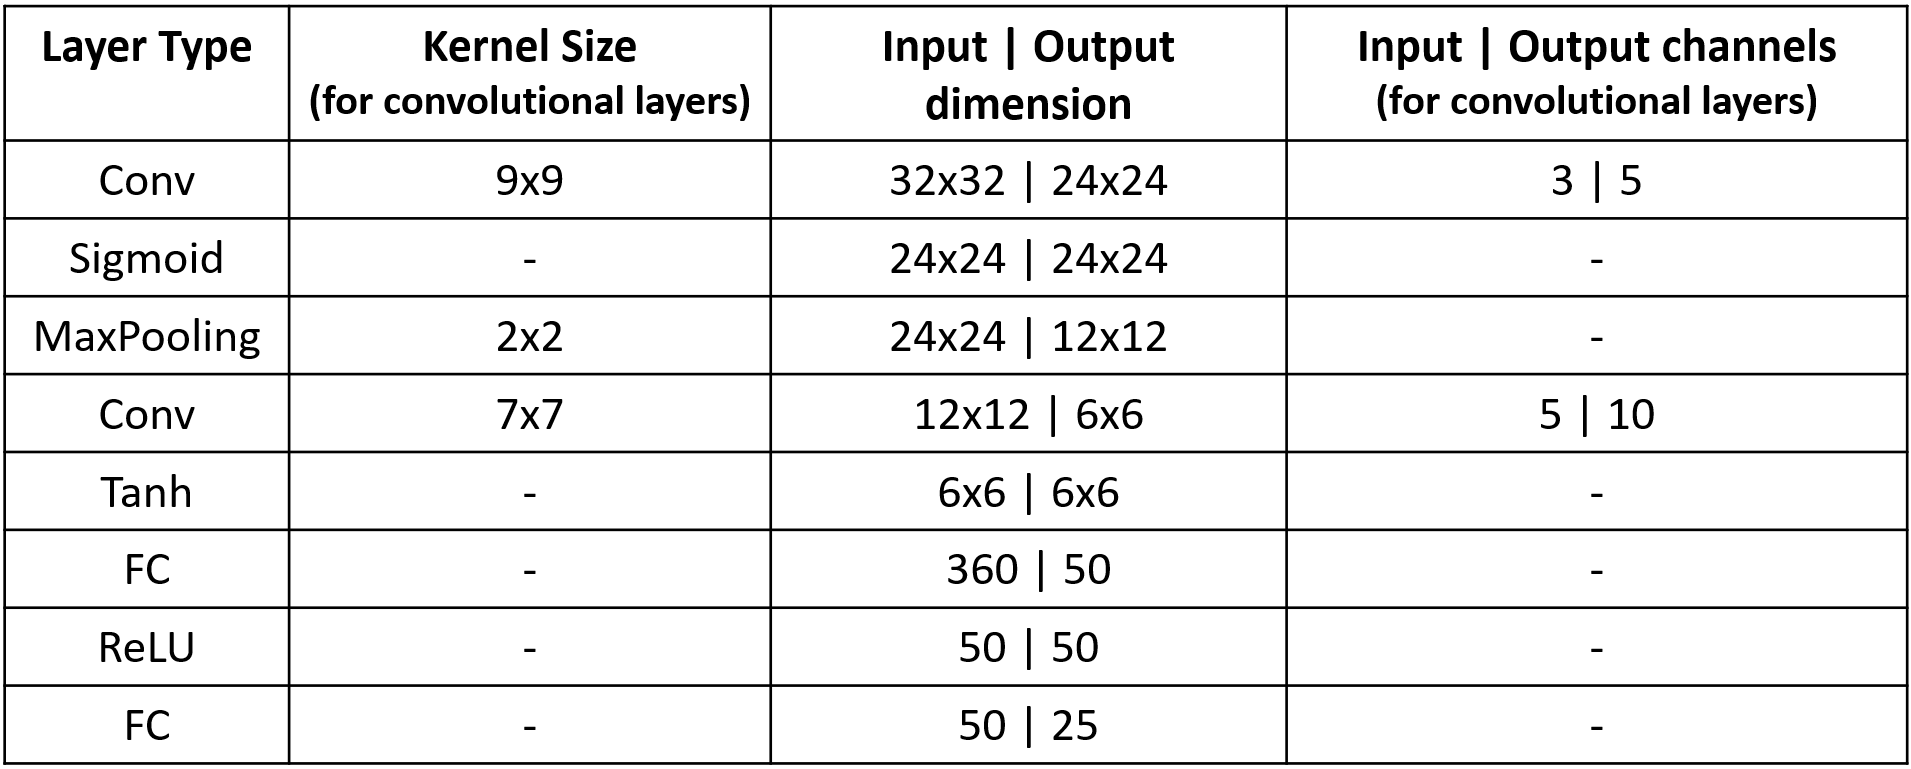

<font color='blue'>Los alumnos deben:
1. Crear el código para el modelo *BaseNet* empleando la librería fastai.
2. Explicar y describir cada una de las capas de la arquitectura *BaseNet*, así como las decisiones de implementación tomadas. Por ejemplo, ¿qué función de pérdida se debería emplear: `CrossEntropyLoss()`, `CrossEntropyLossFlat()` o alguna otra? ¿Se debería incorporar manualmente, en la definición de la red, la función de activación de la capa final (`nn.Softmax()`)? ¿Por qué?
3. Desglosar detalladamente el número de parámetros de esta arquitectura, y cuánto contribuye cada capa a dicho número total. Se debe hacer un `summary()` del modelo para verificar que la arquitectura se ha construido adecuadamente y que el número de parámetros es correcto (es decir, se corresponde con lo esperado).
4. Entrenar el modelo con _Adam_ (incluyendo _early stopping_ con una paciencia de $5$ durante $25$ épocas) y evaluar su rendimiento. En dicha evaluación se debe emplear/mostrar/analizar: la matriz de confusión en entrenamiento, validación y test; la _accuracy_ en entrenamiento, validación y test; y la evolución, por épocas de entrenamiento, tanto de la función de pérdida (en entrenamiento y validación) como de la _accuracy_ (en validación) y el _F1 score (weighted)_ (en validación).



In [3]:
# We get the CIFAR100 dataset
path = untar_data(URLs.CIFAR_100,force_download=True)
path.ls() #visualizamos el contenido de dicho directorio usando el método 'ls()'

(#2) [Path('/root/.fastai/data/cifar100/train'),Path('/root/.fastai/data/cifar100/test')]

Se descarga y descomprime el dataset, proporcionándonos una ruta de acceso a él.
En este caso, el dataset se divide en dos, uno para entrenamiento, y otro para test. Procedemos a visualizar internamente cada uno de los subdirectorios para ver cómo se organizan los datos.

In [4]:
# The CIFAR_100 dataset, as well as the MNIST dataset, follows a common layout for machine learning datasets:
# separate folders for the training set and the validation set (and/or test set).
# Let's see what's inside both the training and test sets
print(path)
print(path.ls())
print((path/'train').ls())
print((path/'test').ls())
train_classes = (path/'train').ls()
test_classes = (path/'test').ls()
print('Nº clases train : ',len(train_classes),' - Nº clases test : ',len(test_classes))

/root/.fastai/data/cifar100
[Path('/root/.fastai/data/cifar100/train'), Path('/root/.fastai/data/cifar100/test')]
[Path('/root/.fastai/data/cifar100/train/insects'), Path('/root/.fastai/data/cifar100/train/reptiles'), Path('/root/.fastai/data/cifar100/train/people'), Path('/root/.fastai/data/cifar100/train/aquatic_mammals'), Path('/root/.fastai/data/cifar100/train/medium_mammals'), Path('/root/.fastai/data/cifar100/train/large_man-made_outdoor_things'), Path('/root/.fastai/data/cifar100/train/fruit_and_vegetables'), Path('/root/.fastai/data/cifar100/train/food_containers'), Path('/root/.fastai/data/cifar100/train/small_mammals'), Path('/root/.fastai/data/cifar100/train/household_electrical_devices'), Path('/root/.fastai/data/cifar100/train/large_natural_outdoor_scenes'), Path('/root/.fastai/data/cifar100/train/household_furniture'), Path('/root/.fastai/data/cifar100/train/non-insect_invertebrates'), Path('/root/.fastai/data/cifar100/train/fish'), Path('/root/.fastai/data/cifar100/train

Vemos que hay 20 clases, pero eso no debe confundirnos. Eso son solo las 20 superclases en que está subdividido el dataset. Véase https://github.com/fastai/dlcert2/blob/master/docs/datasets.md:
"This dataset is just like the CIFAR-10, except it has 100 classes containing 600 images each. There are 500 training images and 100 testing images per class. **The 100 classes in the CIFAR-100 are grouped into 20 superclasses**. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs)."

In [5]:
# Queremos verificar que dentro de cada una de las 20 superclases hay 5 clases,
# lo que da las 100 clases que hay. También queremos verificar que el número de imágenes
# es correcto
print('Clases dentro de la primera superclase (',train_classes[0],'): ', train_classes[0].ls())
for i in range(20):
  print('Número de clases dentro de superclase ',i,': ', len(train_classes[i].ls()))
files_train = get_image_files(path/'train')
files_test = get_image_files(path/'test')
print('Total training images: ', len(files_train))
print('Total test images: ', len(files_test))

Clases dentro de la primera superclase ( /root/.fastai/data/cifar100/train/insects ):  [Path('/root/.fastai/data/cifar100/train/insects/cockroach'), Path('/root/.fastai/data/cifar100/train/insects/beetle'), Path('/root/.fastai/data/cifar100/train/insects/bee'), Path('/root/.fastai/data/cifar100/train/insects/butterfly'), Path('/root/.fastai/data/cifar100/train/insects/caterpillar')]
Número de clases dentro de superclase  0 :  5
Número de clases dentro de superclase  1 :  5
Número de clases dentro de superclase  2 :  5
Número de clases dentro de superclase  3 :  5
Número de clases dentro de superclase  4 :  5
Número de clases dentro de superclase  5 :  5
Número de clases dentro de superclase  6 :  5
Número de clases dentro de superclase  7 :  5
Número de clases dentro de superclase  8 :  5
Número de clases dentro de superclase  9 :  5
Número de clases dentro de superclase  10 :  5
Número de clases dentro de superclase  11 :  5
Número de clases dentro de superclase  12 :  5
Número de cla

Ahora nos quedamos con las primeras 25 clases. Lo que hacemos es eliminar las 75 últimas del dataset.

In [6]:
#https://stackoverflow.com/questions/185936/how-to-delete-the-contents-of-a-folder
import shutil
number_of_classes_to_keep = 25
number_of_superclasses_to_keep = int(number_of_classes_to_keep/5)
print('SUPERCLASES ELIMINADAS:')
for i in range(number_of_superclasses_to_keep,len(train_classes)):
  print(train_classes[i])
  shutil.rmtree(train_classes[i]) #eliminamos el directorio de la superclase 'i' y todo su contenido de forma recursiva
print('SUPERCLASES CONSERVADAS:')
for i in range(number_of_superclasses_to_keep):
  print(train_classes[i])

SUPERCLASES ELIMINADAS:
/root/.fastai/data/cifar100/train/large_man-made_outdoor_things
/root/.fastai/data/cifar100/train/fruit_and_vegetables
/root/.fastai/data/cifar100/train/food_containers
/root/.fastai/data/cifar100/train/small_mammals
/root/.fastai/data/cifar100/train/household_electrical_devices
/root/.fastai/data/cifar100/train/large_natural_outdoor_scenes
/root/.fastai/data/cifar100/train/household_furniture
/root/.fastai/data/cifar100/train/non-insect_invertebrates
/root/.fastai/data/cifar100/train/fish
/root/.fastai/data/cifar100/train/vehicles_2
/root/.fastai/data/cifar100/train/vehicles_1
/root/.fastai/data/cifar100/train/flowers
/root/.fastai/data/cifar100/train/large_carnivores
/root/.fastai/data/cifar100/train/large_omnivores_and_herbivores
/root/.fastai/data/cifar100/train/trees
SUPERCLASES CONSERVADAS:
/root/.fastai/data/cifar100/train/insects
/root/.fastai/data/cifar100/train/reptiles
/root/.fastai/data/cifar100/train/people
/root/.fastai/data/cifar100/train/aquatic_

In [7]:
# También eliminamos las clases en test
for i in range(number_of_superclasses_to_keep,len(test_classes)):
  print(test_classes[i])
  shutil.rmtree(test_classes[i])

/root/.fastai/data/cifar100/test/large_man-made_outdoor_things
/root/.fastai/data/cifar100/test/fruit_and_vegetables
/root/.fastai/data/cifar100/test/food_containers
/root/.fastai/data/cifar100/test/small_mammals
/root/.fastai/data/cifar100/test/household_electrical_devices
/root/.fastai/data/cifar100/test/large_natural_outdoor_scenes
/root/.fastai/data/cifar100/test/household_furniture
/root/.fastai/data/cifar100/test/non-insect_invertebrates
/root/.fastai/data/cifar100/test/fish
/root/.fastai/data/cifar100/test/vehicles_2
/root/.fastai/data/cifar100/test/vehicles_1
/root/.fastai/data/cifar100/test/flowers
/root/.fastai/data/cifar100/test/large_carnivores
/root/.fastai/data/cifar100/test/large_omnivores_and_herbivores
/root/.fastai/data/cifar100/test/trees


Ahora intentamos verificar si los hemos eliminado realmente.

In [8]:
print(path)
train_classes = (path/'train').ls()
test_classes = (path/'test').ls()
print(len(train_classes))
print(len(test_classes))

/root/.fastai/data/cifar100
5
5


Y que el número de ejemplos en training y test es el correcto.

In [9]:
print('Clases dentro de la primera superclase (',train_classes[0],'): ', train_classes[0].ls())
files_train = get_image_files(path/'train')
files_test = get_image_files(path/'test')
print('Total training images: ', len(files_train))
print('Total test images: ', len(files_test))

Clases dentro de la primera superclase ( /root/.fastai/data/cifar100/train/insects ):  [Path('/root/.fastai/data/cifar100/train/insects/cockroach'), Path('/root/.fastai/data/cifar100/train/insects/beetle'), Path('/root/.fastai/data/cifar100/train/insects/bee'), Path('/root/.fastai/data/cifar100/train/insects/butterfly'), Path('/root/.fastai/data/cifar100/train/insects/caterpillar')]
Total training images:  12500
Total test images:  2500


Podemos observar que ahora tenemos el dataset tal y como nos interesa, con 12500 imágenes de entrenamiento y 2500 de test.

Procedemos a definir el DataBlock, estructura muy útil que nos permitirá customizar cada una de las etapas del proceso de preparación de los datos, con el objetivo de que puedan ser insertados en nuestro modelo a entrenar sin ningún problema.

Los parámetros más importantes a especificar son los siguientes:
 Formato de las muestras de trabajo, de la forma (variable independiente,

*   `blocks` : Formato de las muestras de trabajo, de la forma (variable independiente,variable dependiente), tal que...
  - Variable independiente: objeto sobre el cual realizaremos una predicción. En nuestro caso, trabajaremos sobre imágenes, equivalentes a **ImageBlock**.
  - Variable dependiente: objetivo a predecir. En nuestro caso, la categoría (o clase) de la imagen, equivalente a **CategoryBlock**
*   `get_items` : especificar a fastai como obtener una lista de las imágenes de trabajo. Como vamos a trabajar sobre las rutas de las imágenes, emplearemos la función `get_image_files`, función que toma una ruta, y devuelve una lista de todas las imágenes almacenadas en dicha ruta (por defecto, se busca recursivamente).

* `splitter` : nos permite realizar la división de nuestros datos en train y val. Para ello, usaremos `RandomSpliter`, que se encargará de separar los datos, de forma aleatoria, en entrenamiento y validación, especificando los siguientes parámetros:
  - **valid_pct** : porcentaje de los datos que se emplearán para validación. Por defecto, se toma el 20%. En mi caso, procederé a tomar el 10% para validación.
  - **seed** : valor de la semilla aleatoria. Fijar el valor de dicha semilla nos permitirá trabajar siempre con la misma división train/val cada vez que ejecutemos el notebook. Esto es debido a que los ordenadores se limitan a crear listas de numeros que parecen aleatorios, por lo si fijamos el punto de comienzo de la lista (que es justamente la semilla), obtendremos siempre la misma lista.

* `get_y` : indicar a fastai la función que debe utilizar para crear la etiqueta de cada dato del dataset. En este caso, como vamos a trabajar con las clases (no con las superclases), indicamos que debe usar **parent_label**,  función que devuelve el nombre de la carpeta donde se localiza la imagen, y que se corresponde justamente con su clase.

Es importante asegurarnos de que todas las imágenes de trabajo tengan un mismo tamaño, ya que nuestro modelo no recibirá las imágenes de una en una, sino que trabajará sobre lotes, que internamente se representan mediante un tensor, obligando a que tengan dichas imágenes las mismas dimensiones. En este caso, no hace falta incluir en el datablock ningún resize, ya que todas las imágenes del dataset tienen un mismo tamaño (imágenes RGB 32x32).

In [10]:
#comenzamos creando el datablock
dblock = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(valid_pct=0.1,seed=42), #por defecto, valid_pct=0.2, lo que supone tomar el 20% para validación
                 get_y=parent_label)
#el siguiente método intentará generar un lote de muestras a partir de la fuente proporcionada, y usando el datablock definido
#útil para comprobar que el datablock se ha definido correctamente
dblock.summary(path/'train')

Setting-up type transforms pipelines
Found 12500 items
2 datasets of sizes 11250,1250
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/cifar100/train/medium_mammals/fox/red_fox_s_000037.png
    applying PILBase.create gives
      PILImage mode=RGB size=32x32
  Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /root/.fastai/data/cifar100/train/medium_mammals/fox/red_fox_s_000037.png
    applying parent_label gives
      fox
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(11)

Final sample: (PILImage mode=RGB size=32x32, TensorCategory(11))


Found 12500 items
2 datasets of sizes 11250,1250
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': Tru

Hemos empleado el método `summary`, útil para comprobar que nuestro datablock se ha construido con éxito, generando, a modo de prueba, un lote a partir de la fuente entregada, y comprobando que el procedimiento interno se lleva a cabo sin ningún problema.

Internamente, se llevan a cabo los siguientes pasos ordenados:
1. División del dataset en train y val, tal y como especificamos.
2. Creación de una muestra (imagen,categoría) a partir de la ruta de una imagen.
3. Se aplican las transformaciones a nivel de elemento especificadas. En este caso, únicamente se transforma la imagen en un tensor.
4. Se combinan las 4 imágenes para obtener un lote.

In [ ]:
doc(DataBlock.dataloaders)

,Type,Default,Details,
source,,,The data source,
path,str,.,Data source and default `Learner` path,
verbose,bool,False,Show verbose messages,
bs,int,64,Size of batch,
shuffle,bool,False,Whether to shuffle data,
num_workers,int,None,Number of CPU cores to use in parallel (default: All available up to 16),
do_setup,bool,True,Whether to run `setup()` for batch transform(s),
pin_memory,bool,False,,
timeout,int,0,,
batch_size,NoneType,None,,


A continuación, construimos el **Dataloader**, insertando en el datablock los datos a preparar para ser posteriormente insertados en nuestro modelo.

El dataloader generado contiene los dataloaders de train y val (datos de entrenamiento y validación preparados para ser usados por el modelo).Este objeto se encargará de ir proporcionando al modelo los datos de trabajo organizados en lotes. Los parámetros más relevantes a indicar son los siguientes:
* **dataset** : ruta del dataset donde se almacenan los datos a cargar.
* **bs** (int) : tamaño del batch. En mi caso, usaré lotes de 64 imágenes.
* **drop_last** : especificar si queremos descartar o no los elementos que sobren al agrupar los elementos del dataset en lotes. En mi caso, usaré `drop_last=False`, para evitar descartar las imágenes que sobren tras hacer agrupaciones sobre el dataset de tamaño 64.
* **shuffle** : los lotes realmente se generan de forma dinámica durante el entrenamiento. Este parámetro, al activarlo, nos permitirá reordenar los datos de forma aleatoria cada vez que se lea/itere de forma completa el dataloader, es decir, al principio de cada época, lo que nos permite trabajar con lotes que pueden contener diferentes imágenes en función de la época. Este barajado se aplica únicamente sobre los datos de train.


Sin embargo, me decantaré por usar la clase **RandomSampler** en lugar del parámetro **shuffle**, debido a que este último no nos permite controlar de forma explícita el generador de números aleatorios, lo que hace que el proceso de entrenamiento sea menos reproducible.

Empleando **RandomSampler** podremos fijar la semilla y por ende, muestrear los datos de la misma manera en cada ejecución.

**Nota**: RandomSampler debe trabajar únicamente sobre los datos de entrenamiento, no validación. Por ende, será empleado tras generar el train dataloader.


In [ ]:
doc(RandomSampler)

Esta clase requiere especificar una serie de atributos:
* `data_source` : dataset a muestrear. Dicho muestreo se realiza al principio de cada época (al igual que **shuffle**)
* `replacement` : tomar muestras con reemplazo, es decir, posibilidad de que se tome una misma imagen varias veces. Por defecto, **False**
* `num_samples` : nº de muestras que se extraen del dataset. Si no se especifica nada, se toman tantas como tamaño tenga el dataset. Usaremos el valor por defecto, tal que, al comienzo de cada época, se reordenan de forma aleatoria **todos** los elementos del dataset de entrenamiento y se van generando los lotes del tamaño indicado en el dataloader.
* `generator` : objeto de tipo Generator. Generador de números aleatorios que se usará para muestrear.

In [11]:
gen = torch.Generator().manual_seed(42)

Numero de ejemplos de entrenamiento (una vez descartados los de validacion): 11250
Numero de ejemplos de validacion: 1250


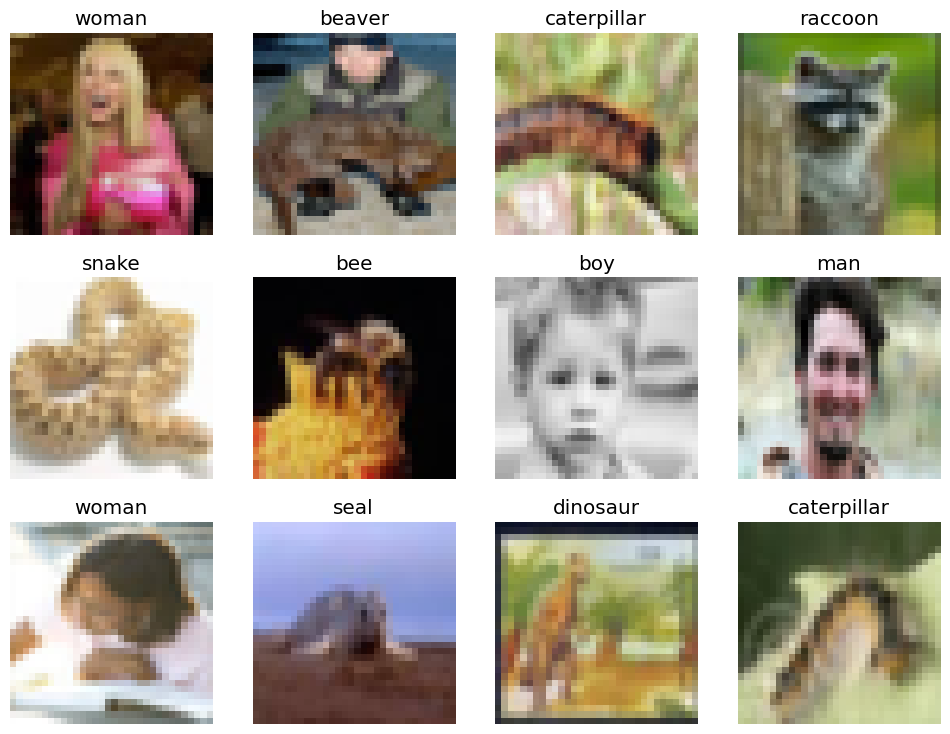

In [12]:
#'dls' almacena los dataloaders de train y val
dls=dblock.dataloaders(path/'train',bs=64,drop_last=False)
#asignamos un randomsampler como herramienta para muestrear los datos de train, al comienzo de cada época
dls.train.sampler = RandomSampler(dls.train.dataset,generator=gen)
dls.show_batch(max_n=12)

print('Numero de ejemplos de entrenamiento (una vez descartados los de validacion):', len(dls.train_ds))
print('Numero de ejemplos de validacion:', len(dls.valid_ds))

Procedemos a visualizar el nº de lotes que se emplearán tanto para entrenamiento como para validación.

In [13]:
print("Tamaño de lote fijado : ",dls.train.bs)
print("Nº de lotes que deberían de generarse en training : ",len(dls.train_ds)/dls.train.bs)
print("Nº de lotes de entrenamiento : ",len(dls.train))

Tamaño de lote fijado :  64
Nº de lotes que deberían de generarse en training :  175.78125
Nº de lotes de entrenamiento :  176


In [14]:
print("Tamaño de lote fijado : ",dls.valid.bs)
print("Nº de lotes que deberían de generarse en validación : ",len(dls.valid_ds)/dls.valid.bs)
print("Nº de lotes de validación : ",len(dls.valid))

Tamaño de lote fijado :  64
Nº de lotes que deberían de generarse en validación :  19.53125
Nº de lotes de validación :  20


Hemos usado `show_batch` directamente sobre el dataloader, visualizando, como ejemplo, un lote de 12 imágenes, indicando tanto la imagen como la clase a la que pertenece. Además, imprimimos el nº de muestras de entrenamiento y validación generadas, confirmando que los dataloaders correspondientes se han creado con éxito.

Procedemos a mostrar lotes de 12 elementos de train y val, respectivamente.

Example of training data


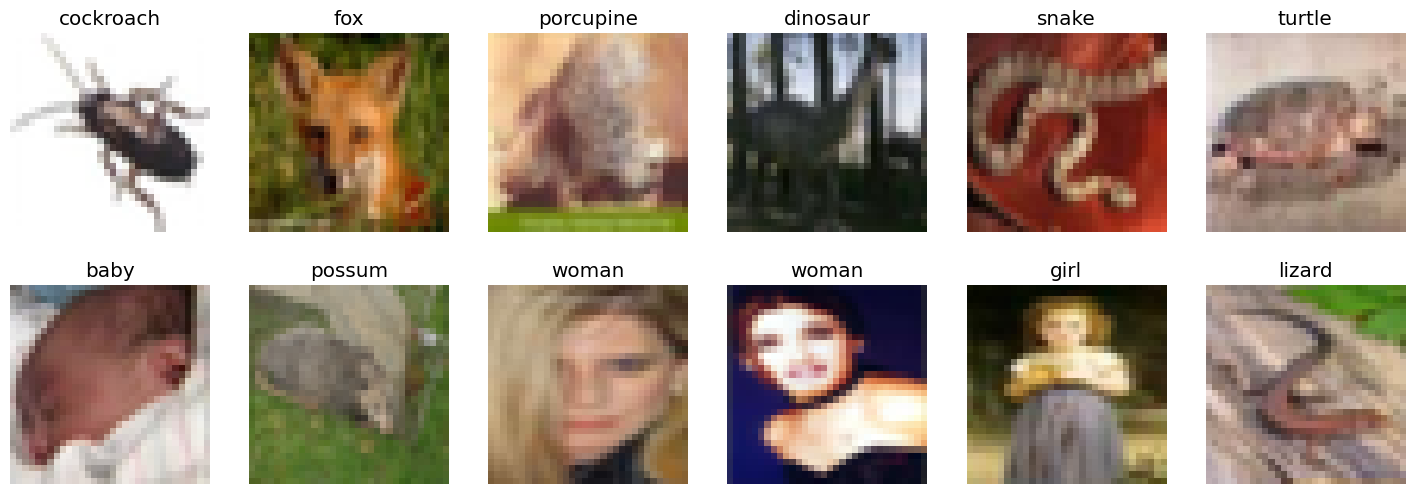

In [15]:
print('Example of training data')
dls.train.show_batch(max_n=12, nrows=2)

Example of validation data


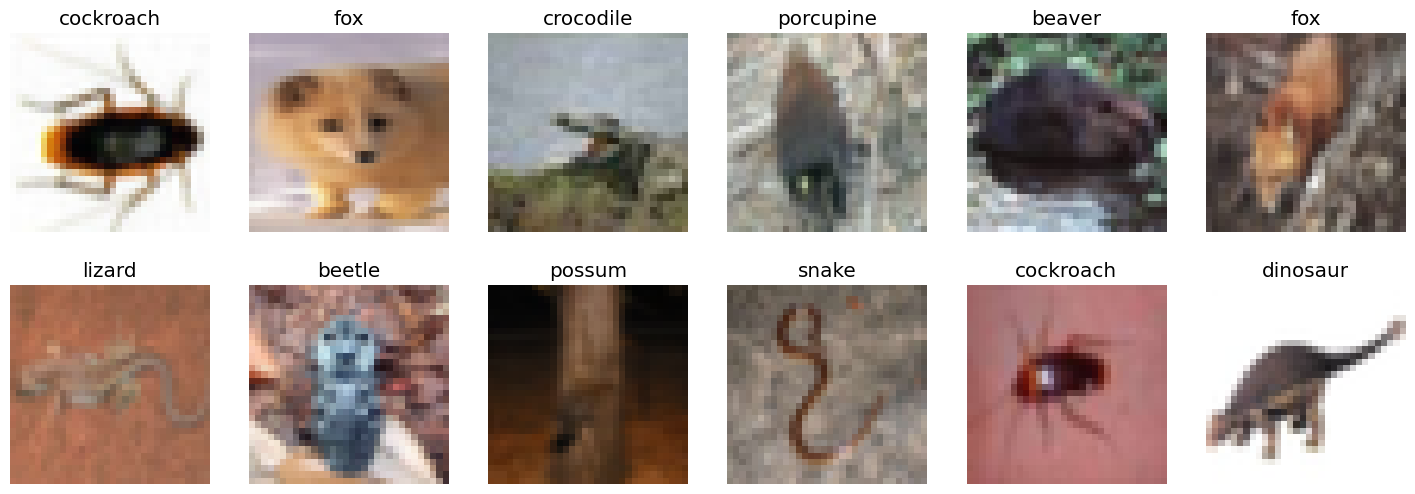

In [16]:
print('Example of validation data')
dls.valid.show_batch(max_n=12, nrows=2)

A continuación, se implementa la CNN que emplearemos para resolver el problema de clasificación. Las capas empleadas son las siguientes:

<mark>**1. CAPA DE CONVOLUCIÓN** </mark>, indicando los parámetros siguientes:
  - `in_channels=3` : la primera capa de nuestra CNN recibirá como entrada una imagen de tamaño 32x32x3.
  - `out_channels=5` : queremos obtener como salida una imagen con 5 canales.
  - `kernel_size=9` : emplearemos un kernel de tamaño 9x9,con una profundidad equivalente al nº de canales de la imagen de entrada.

  Para obtener una imagen de salida de tamaño 24x24, debemos especificar adecuadamente los valores de `stride` (desplazamiento del kernel por la imagen) y `padding` (por defecto 0), con el objetivo de que tras aplicar las convoluciones correspondientes sobre la imagen original, las diferentes capas de la imagen de salida sean de tamaño 24x24. Podemos tomar los valores a partir de la siguiente fórmula:



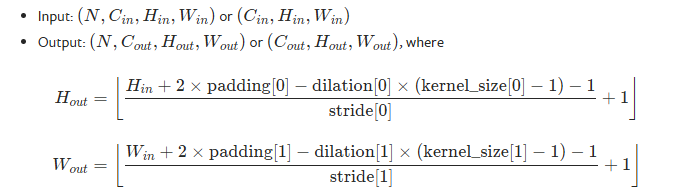

Antes de nada, comentar que **dilation** hace referencia al espacio entre los elementos del kernel. Por defecto, 1. Reemplazando las variables de la fórmula (podemos emplear cualquier de las dos ya que estamos trabajando a partir de una imagen cuadrada), obtenemos, como valores válidos (aunque no es la única solución), un `stride=1` y un `padding=0`.

Con estos valores, conseguimos pasar de una imagen 32x32x3 a una imagen 24x24x5. En este caso, reducimos un 25% en cada dirección (horizontal y vertical), tal que el tamaño de la imagen de salida, expresada en función de las filas y columnas de la original será:


$$\text{tamaño_imagen_salida} = \frac{3}{4} \times \text{filas_origen} \times \frac{3}{4} \times \text{columnas_origen}$$

$$\text{tamaño_imagen_salida} = \frac{9}{16} \times \text{filas_origen} \times \text{columnas_origen}$$

Para hacer frente a esa reducción espacial, podemos optar por incrementar el nº de canales de la imagen de salida a partir del factor de reducción que lleva a cabo dicha capa:

$$ 3 \times \frac{16}{9} = \frac{16}{3} ≈ 5 $$

Pero...¿por qué realizamos este paso?

Tenemos que evitar introducir en nuestra red capas convolucionales que reduzcan la imagen manteniendo siempre el mismo nº de canales, ya que esto supondría que la cantidad de cómputo realizada en la red se vaya decrementando más y más conforme vamos pasando por capas más profundas. Al fin y al cabo, un kernel se va aplicando sobre los diferentes píxeles de la imagen de entrada (teniendo en cuenta el stride y padding indicado), por lo que una reducción daría lugar a que la siguiente capa convolucional reciba una imagen de entrada más pequeña, y por ende, realice un menor nº total de multiplicaciones. Pero tal y como sabemos, las capas más profundas necesitan calcular características semánticamente ricas (características más complejas y abstractas), que suelen requerir una mayor capacidad de cómputo. Por tanto, optamos por incrementar los canales de salida para hacer frente a una reducción del tamaño de la imagen de entrada.

Capas más profundas suelen requerir áreas receptoras más grandes, con el fin de aprender características más ricas semanticamente. Denomino 'área receptora' al trozo de la imagen de entrada sobre el que se aplica la convolución, para obtener un valor resultante (equivale a emplear kernels que consideren un entorno más grande del píxel de trabajo, recopilando más información para ser capaz de aprender características más complejas). Todo esto implicará emplear muchos más pesos para ser capaces de abordar el aprendizaje de cosas más complejas.

Por esta razón, generamos 5 capas de salida. Para capas convolucionales más profundas, no se empleará el factor de reducción correspondiente para calcular el nº de capas de salida ya que podría suponer un incremento del cómputo muy drástico, incrementando muchísimo el nº de parámetros que emplea dicha capa. Optaremos por simplemente duplicar el nº de canales, manteniendo así un equilibro entre la eficiencia computacional y la capacidad de aprendizaje de la capa.

<mark>**2. FUNCIÓN DE ACTIVACIÓN SIGMOIDE** </mark>

Recordemos que las funciones de activación son funciones no lineales, que nos permiten justamente introducir no linealidad en nuestro modelo, y por ende, modelar funciones más complejas. Además, debemos de colocar una función no-lineal entre dos capas lineales, ya que si colocasemos varias capas lineales directamente una después de la otra, se podrían reemplazar todas ellas por una sola capa lineal que realizase el mismo procedimiento. Colocando una función no lineal entre ellas, conseguimos que cada capa lineal esté totalmente desacoplada del resto, pudiendo hacer por ella misma su propio trabajo.

En este caso, usamos después de la primera capa convolucional, la funcion **sigmoide**.



---



<mark>**3. CAPA MAXPOOL** </mark>,   con los siguientes prámetros:

* `kernel_size = 2` : para cada una de las capas de la imagen de entrada...
  - Se particiona dicha capa en ventanas de tamaño 2x2.
  - Para cada ventana, se considera el máximo valor.
* `stride = 2` : desplazamiento de la ventana. En este caso, se desplaza dos píxeles.

Tras realizar la configuración previa, esta capa tomará como entrada una imagen con dimensiones 24x24x5, y devolverá como salida una imagen 12x12x5.

El objetivo de esta capa es resumir la información almacenada en cada una de las capas de la imagen de entrada, preservando las capas.



---



<mark>**4. CAPA DE CONVOLUCIÓN** </mark>, indicando los parámetros siguientes:
  - `in_channels = 5` : recibirá como entrada una imagen de tamaño 12x12x5.
  - `out_channels = 10` : queremos obtener como salida una imagen 6x6x10 (10 canales).
  - `kernel_size = 7` : emplearemos un kernel de tamaño 7x7,con una profundidad equivalente al nº de canales de la imagen de entrada.

  Para tomar los valores correspondientes de los parámetros `stride` y `padding`, emplearemos las mismas fórmulas comentadas en la primera capa convolucional, tal que, tras reemplazar las variables conocidas por sus respectivos valores, obtendremos, como posible solución, `stride = 1` y `padding = 0`.



---



<mark>**5. FUNCIÓN DE ACTIVACIÓN TANGENCIAL** </mark>



---



<mark>**6. FLATTEN** </mark>

Esta capa se emplea únicamente para adaptar la salida de la última capa convolucional, de tal forma que pueda ser entregada a la siguiente capa de nuestra CNN (capa lineal) con la estructura adecuada.

Básicamente, esta capa transformará el tensor de dimensiones 10x6x6 (canales, anchura, altura) en un tensor unidimensional (vector), ya que la siguiente capa a aplicar es una capa fully-conected, que espera recibir como entrada un vector y no un tensor multidimensional.




---



<mark>**7. CAPA FULLY-CONECTED (O LINEAL)** </mark>

Capa lineal clásica de una red neuronal, donde todos los nodos de entrada están asociados a todos y cada uno de los nodos de salida. Cada nodo de salida realiza una suma ponderada (pesos) de las salidas de todos los nodos de la capa anterior, agregando un bias (dependiente de dicho nodo de salida).

En este caso, se recibe como entrada un vector con las salidas devueltas por la anterior capa (capa convolucional), y se devuelven las salidas indicadas:
- `in_features`: 10 × 6 × 6
- `out_Features`: 50



---



<mark>**8. FUNCIÓN RELU** </mark>

Antes de volver a aplicar una nueva capa lineal, empleamos una función de activación. En este caso, Relu, que tiene como objetivo poner a 0 todos aquellos valores negativos.



---



<mark>**9. CAPA FULLY-CONECTED (O LINEAL)** </mark>

Última capa de nuestra red. Simplemento conecta los 50 nodos de entrada con 25 nodos de salida, que representan a cada una de las clases del dataset de trabajo.

In [17]:
def get_model():
  return sequential(
      nn.Conv2d(in_channels=3,out_channels=5,kernel_size=9), #usamos formulita de la documentacion de conv2d
      #obtengo como salida 24x24x5
      nn.Sigmoid(),
      nn.MaxPool2d(kernel_size=2,stride=2), #resumo informacion sobre cada canal de la imagen de entrada
      #obtengo como salida 12x12x5
      nn.Conv2d(in_channels=5,out_channels=10,kernel_size=7), #padding=0, stride=1, usando de nuevo la formula
      #btengo como salida 6x6x10
      nn.Tanh(),
      nn.Flatten(),
      #aplanamos a una dimension para poder trabajar a posteriori con nn.Linear (=fully conected)
      nn.Linear(10 * 6 * 6, 50),
      nn.ReLU(),
      nn.Linear(50, 25)
      #las 25 salidas hacen referencia a las 25 clases resultantes
    )

get_model() #descripcion del modelo construido

Sequential(
  (0): Conv2d(3, 5, kernel_size=(9, 9), stride=(1, 1))
  (1): Sigmoid()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(5, 10, kernel_size=(7, 7), stride=(1, 1))
  (4): Tanh()
  (5): Flatten(start_dim=1, end_dim=-1)
  (6): Linear(in_features=360, out_features=50, bias=True)
  (7): ReLU()
  (8): Linear(in_features=50, out_features=25, bias=True)
)

El resultado previo nos muestra el modelo definido.

In [18]:
#obtenemos un lote para visualizar cómo son las muestras de dicho lote
x, y = dls.one_batch()
print(x.shape,y.shape) #64x3x32x32 (batch,canales,altura,anchura)
print(y)

torch.Size([64, 3, 32, 32]) torch.Size([64])
TensorCategory([ 0,  9, 22,  2,  8, 19, 13,  5, 12,  9, 14, 17,  4,  7,  2, 19,  5, 18,  0, 10,  1, 13, 16, 20, 12, 20,  3, 15,  4, 13,  6, 15, 11,  7,  2, 13, 12, 23, 23, 24, 10,  5, 21, 15,  1, 10,
                10, 21, 10,  7,  9, 19, 16,  0, 11, 12,  7, 24, 18, 11, 23, 14,  0, 16], device='cuda:0')


El orden de las categorías viene definido en el vocabulario de los DataLoaders, lo que nos permitirá conocer los índices de las diferentes clases y el orden en el que se obtendrán las probabilidades de las clases.

In [19]:
dls.vocab

['baby', 'beaver', 'bee', 'beetle', 'boy', 'butterfly', 'caterpillar', 'cockroach', 'crocodile', 'dinosaur', 'dolphin', 'fox', 'girl', 'lizard', 'man', 'otter', 'porcupine', 'possum', 'raccoon', 'seal', 'skunk', 'snake', 'turtle', 'whale', 'woman']

Procedemos a definir el objeto de aprendizaje (datos preparados + modelo construido a entrenar). Para ello, instanciamos la clase Learner, indicando los siguientes parámetros:

*   `dls` : Dataloaders
* `model` : modelo a entrenar (BaseNet)
* `metrics` : métricas para medir el rendimiento de nuestro modelo sobre el conjunto de validación (accuracy y F1 score).
* `loss_func` : función de pérdida a emplear
* `opt_func` : algoritmo de optimización para el entrenamiento

En cuanto a la **función de pérdida** a emplear...


Como estamos ante un problema de clasificación, emplearemos la función de pérdida **Cross-Entrophy**, que lleva a cabo el siguiente procedimiento de forma interna:

1. Uso de softmax, función de activación sobre la capa final de la CNN, encargada de normalizar las salidas de la red, para que todas tomen valores en [0,1] y la suma de todas ellas sea 1. Recordemos que la red devolvía, para cada imagen de entrada, 25 salidas, que tras aplicar softmax, nos permite interpretar las salidas como la probabilidad de que dicha imagen pertenezca a cada una de las posibles clases.

Si visualizamos la expresión de dicha función, se basa en el uso de la exponencial, lo que nos permite obtener valores positivos y amplificar el hecho de que una de las salidas sea un poco más grande que otra.

$$\text{softmax}(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{N} e^{z_j}}$$

2. Se toma la probabilidad asociada a la clase correcta y se evalua sobre dicho valor el logaritmo negativo. Esto tiene sentido ya que queremos que la pérdida sea muy pequeña cuando la predicción es buena (el valor seleccionado es próximo a 1, por lo que su logaritmo negativo sería aproximadamente 0) y una pérdida grande cuando la predicción sea mala (probabilidad de pertenecer a la clase real próxima a 0, lo que implica un logaritmo negativo muy alto).

Al trabajar con lotes de imágenes, se devolverá la media de las pérdidas de las imágenes que conforman dicho lote.

Realmente no emplearemos directamente CrossEntrophy, sino `CrossEntropyLossFlat`, una versión adaptada de la función de pérdida comentada, debido a que nuestro modelo devolverá un tensor de salidas de la forma **(batch_size,num_classes, ...)**. `CrossEntropyLoss` espera que las entradas tengas las dimensiones **(batch_size,num_classes)**, por lo usando esta versión, se aplanará automáticamente las dimensiones adicionales en caso de que nuestro modelo entregue salidas con más dimensiones de las esperadas.

Por último, indicar que se empleará el algoritmo de optimización Adam, optimizador que combina las ideas de SGD con momento y RMSProp, empleando como dirección una media móvil de los gradientes (teniendo en cuenta, no solamente el gradiente actual, sino el historial de gradiente pasados, suavizando las actualizaciones) y dividiendo por la raíz cuadrada de la media móvil de los gradientes al cuadrado, permitiendo usar una tasa de aprendizaje adaptada a cada uno de los parámetros que vaya tomando el modelo.

Esto último permite acelerar el entrenamiento, usando una tasa de aprendizaje más alta para pesos que necesitan cambiar mucho más, pero tasas más pequeñas para aquellos que ya son lo suficientemente buenos (próximos al punto del espacio paramétrico donde la función de pérdida alcanza un mínimo global).

Esta media se calcula usando el cuadrado de los gradientes para evitar calcular directamente la media de gradientes muy grandes positivos y negativos, que darían como resultado un valor próximo a 0. Así, si los gradientes de diferentes pesos son próximos a cero, emplearemos tasas más grandes para salir de esas zonas donde la gráfica de la función de pérdida se aplana, y en consuencia, gradientes más pequeños, ya que el cambio de la función en un entorno pequeño de dicho punto es casi nulo. Por otra parte, si los gradientes son muy altos para determinados pesos, reducimos la tasa de aprendizaje, evitando la divergencia.

In [20]:
learn = Learner(dls, get_model(), metrics=[accuracy,F1Score(average='weighted')],
                loss_func=CrossEntropyLossFlat(),  #new loss-function
                opt_func=Adam)

Una vez definido nuestro learner, procedemos a visualizar nuevamente la estructrura del modelo a entrenar, obteniendo además el total de parámetros que emplea cada una de las capas, y el total de parámetros del modelo.

In [21]:
learn.summary()

Sequential (Input shape: 64 x 3 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 5 x 24 x 24    
Conv2d                                    1220       True      
Sigmoid                                                        
____________________________________________________________________________
                     64 x 5 x 12 x 12    
MaxPool2d                                                      
____________________________________________________________________________
                     64 x 10 x 6 x 6     
Conv2d                                    2460       True      
Tanh                                                           
____________________________________________________________________________
                     64 x 360            
Flatten                                                        
____________________________________________________________________________
                     64 x 50     

* La **primera capa convolucional** emplea 1220 parámetros, que se obtienen de la siguiente forma: un kernel de tamaño 9x9x3 y un bias por cada canal de salida, lo que equivale a trabajar con un total de 1215 pesos y 5 bias, obteniendo los 1220 parámetros de nuestra capa convolucional.

* La **segunda capa convolucional** emplea 2640 parámetros, obtenidos de la siguiente forma: un kernel de 7x7x5 pesos y un bias por cada canal de salida. Como tenemos 10 canales de salida, esto supone un total de 2450 pesos y 10 bias, lo que genera los 2460 parámetros que emplea esta capa.

* La **primera capa lineal** conecta 360 nodos de entrada con los 50 nodos de salida. Esto supone que cada nodo de salida trabaja con 360 pesos y 1 bias, por lo que teniendo en cuenta el total de nodos de salida, estaremos trabajando en esta capa con 18000 pesos y 50 bias (18050 parámetros).

* La **segunda capa lineal** (última capa de la CNN) conecta 50 nodos de entrada con 25 nodos de salida, por lo que cada nodo de salida emplea 50 pesos y 1 bias, suponiendo un total de 1250 pesos y 25 bias (1275 parámetros).

También podemos desglosar todo esto a nivel de código. Pongo, como ejemplo, el código asociado para obtener los pesos y bias que emplea la primera capa convolucional.

In [22]:
m=learn.model[0]
m

Conv2d(3, 5, kernel_size=(9, 9), stride=(1, 1))

In [23]:
print(m.weight.shape)
print(m.bias.shape)

torch.Size([5, 3, 9, 9])
torch.Size([5])


Tal y como se comentó anteriormente, podemos ver que esta capa emplea `5*3*9*9` = 1215 pesos, y 5 bias, haciendo un total de 1220 parámetros.

Para entrenar nuestro modelo emplearemos la función `fit_one_cycle`. Este método emplea una estatregia llamada Ciclo de Aprendizaje 1-Ciclo, variando la tasa de aprendizaje y el momento a lo largo de las épocas. La tasa de aprendizaje cambia en dirección opuesta al momento. De forma resumida, se llevan a cabo los siguientes pasos:
- Se especifica la tasa de aprendizaje óptima, la cual podemos buscar empleando previamente el método `lr_finder`
- Se aplica la política 1cycle usando como tasa de aprendizaje máxima la pasada como parámetro (la tasa que hemos seleccionado como óptima):
  1. Vamos incrementando progresivamente la tasa de aprendizaje desde la tasa de inicio (obtenida dividiendo la tasa máxima por un determinado factor, por defecto, 25) hasta la tasa máxima permitida. Al mismo tiempo, vamos decrementando el momento desde su valor máximo hasta su valor mínimo.
  2. Una vez realizado el paso 1, y alcanzar la tasa máxima permitida y el momento mínimo permitido, procedemos a realizar el proceso inverso: vamos decrementando progresivamente la tasa de aprendizaje desde su valor máximo hasta el mínimo, al mismo tiempo que incrementamos el momento desde su mínimo hasta su máximo. Realmente en esta segunda fase no paramos tras alcanzar el mínimo establecido, sino hasta un nuevo mínimo que se obtiene tal que `lr_max/div_final`, siendo `div_final=1e5 ` por defecto

Tal y como indica su nombre, realizamos un sólo ciclo, equivalente a desplazarnos desde un valor origen hasta un valor final, y volviendo luego al origen, consiguiendo un entrenamiento eficiente, ya que se permite tanto **explorar rápidamente diferentes regiones del espacio paramétrico** (1º paso del método) como realizar un ajuste fino y **convergencia más estable y precisa** (2º paso del método).


**¿Cómo buscar la tasa de aprendizaje óptima?**

Simplemente entrenamos el modelo usando un rango amplio de tasas de aprendizaje (una tasa de aprendizaje por cada iteración) y visualizamos la pérdida tras cada iteración: comenzamos empleando una tasa de aprendizaje muy pequeña para un lote, evaluamos la pérdida y luego incrementamos esa tasa por algún porcentaje (por ejemplo, duplicándola cada vez). Procedemos a pasar un nuevo lote, calculamos la pérdida, y volvemos a duplicar la tasa de nuevo. Seguiremos realizando todo esto hasta que la pérdida comience a empeorar. Ese es justamente el punto donde debemos evitar avanzar más. Podemos optar por varias estrategias a la hora de seleccionar la tasa de aprendizaje óptima:
- `minimun` : Escoger aquella levemente inferior a la tasa donde la función de pérdida alcanza un mínimo (por ejemplo, escogiendo el mínimo dividido entre 10).
- `steep` : Escoger la última tasa donde la función de pérdida estaba claramente decreciendo, es decir, seleccionar la tasa asociada a la mayor pendiente o mayor magnitud de cambio en la pérdida.
- `valley` : Escoger aquella que genera un valle en el gráfico de la funció de perdida (método empleado por defecto en `Learner.lr_find`
- `slide`

Sin embargo, los dos primeros métodos no suelen dar las mejores estimaciones sobre una buena tasa de aprendizaje. decantándonos por tanto por los otros métodos: `slide` y `valley`, sobre todo por este último. Ofrezco justo a continuación una imagen donde se observan varios experimentos en los que se ha empleado un mismo modelo seleccionando diferentes tasas de aprendizaje óptimas:
* Leslie Smith = Steep
* ESRI = Valley
* Novetta = Slide

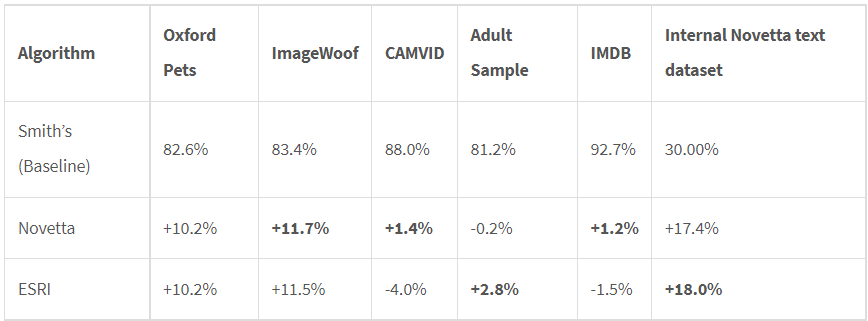

Tal y como se ha comentado anteriormente, `valley` y `slide` ofrecen muchos mejores resultados, destacando, por poco, `valley`. Este será el método escogido para seleccionar la tasa óptima.

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

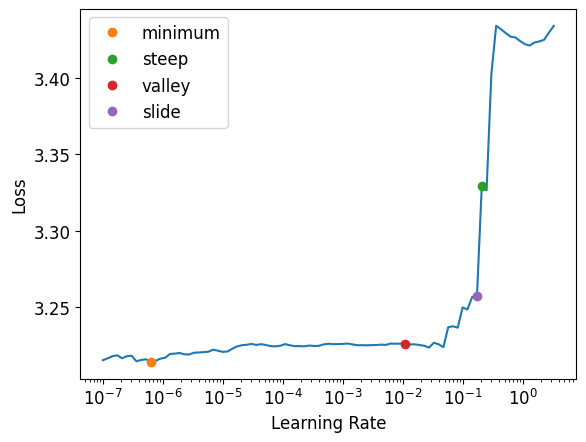

In [24]:
weights_pre_lr_find = L(learn.model.parameters())
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
weights_post_lr_find = L(learn.model.parameters())

In [ ]:
#doc(Learner.lr_find)

Usando los valores por defecto de ciertos parámetros del método `lr_find()`, obtenemos la gráfica de la función de pérdida evaluada empleando tasas de aprendizaje que van desde $10^{-7}$ hasta $10$, usando un total de 100 iteraciones, y en escala logarítmica.

Comprobamos que los valores de los parámetros del modelo (inicializados de forma alaeatoria al construir el modelo) no hayan cambiado tras realizar la búsqueda.

In [25]:
test_eq(weights_pre_lr_find, weights_post_lr_find)

In [26]:
print(f"Tasa de aprendizaje óptima escogida:{round(lrs.valley,5)}")

Tasa de aprendizaje óptima escogida:0.01096


Además, añadiré una serie de acciones a realizar durante el proceso de entrenamiento:
* `SaveModelCallback()` : guarda el mejor modelo durante el entrenamiento. Por defecto, guardará aquel que tenga la menor pérdida en validación.
* `EarlyStoppingCallback()` : nos permite aplicar early-stopping, deteniendo el proceso de enterenamiento cuando la cantidad monitoreada deje de mejorar. Por defecto, se monitorea la pérdida en validación, especificando dos parámetros relevantes para dicho proceso:
  - `min_delta` : mínima mejora que tiene que producirse entre el último valor obtenido y el mejor obtenido hasta la fecha. Es decir, $$pérdida\_actual<=mejor\_perdida-min\_delta$$
  - `patience` : nº de épocas a esperar en el momento en el que no se detecta una mejora (paciencia que tenemos). Si durante ese período de paciencia se vuelve a obtener una mejora del modelo, se reinicia el contador.

  En mi caso, usaré `min_delta=0.01` y `patience=5`

In [ ]:
#doc(Learner.fit_one_cycle)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,3.138666,3.074678,0.077600,0.028122,00:13
1,2.870448,2.791640,0.137600,0.091131,00:13
2,2.761493,2.778478,0.161600,0.131475,00:13
3,2.665449,2.595828,0.211200,0.179187,00:11
4,2.652823,2.701841,0.176000,0.137832,00:11
5,2.662567,2.754602,0.196800,0.173034,00:13
6,2.638702,2.636118,0.219200,0.186245,00:12
7,2.609085,2.577206,0.233600,0.208699,00:12
8,2.563162,2.706087,0.207200,0.183339,00:10
9,2.539826,2.612692,0.223200,0.201503,00:12


Better model found at epoch 0 with valid_loss value: 3.0746777057647705.
Better model found at epoch 1 with valid_loss value: 2.791640043258667.
Better model found at epoch 2 with valid_loss value: 2.7784781455993652.
Better model found at epoch 3 with valid_loss value: 2.595828056335449.
Better model found at epoch 7 with valid_loss value: 2.5772063732147217.
Better model found at epoch 12 with valid_loss value: 2.545839548110962.
Better model found at epoch 14 with valid_loss value: 2.5429651737213135.
Better model found at epoch 15 with valid_loss value: 2.521094799041748.
Better model found at epoch 16 with valid_loss value: 2.503314256668091.
Better model found at epoch 18 with valid_loss value: 2.478877544403076.
Better model found at epoch 20 with valid_loss value: 2.470113515853882.
No improvement since epoch 18: early stopping


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

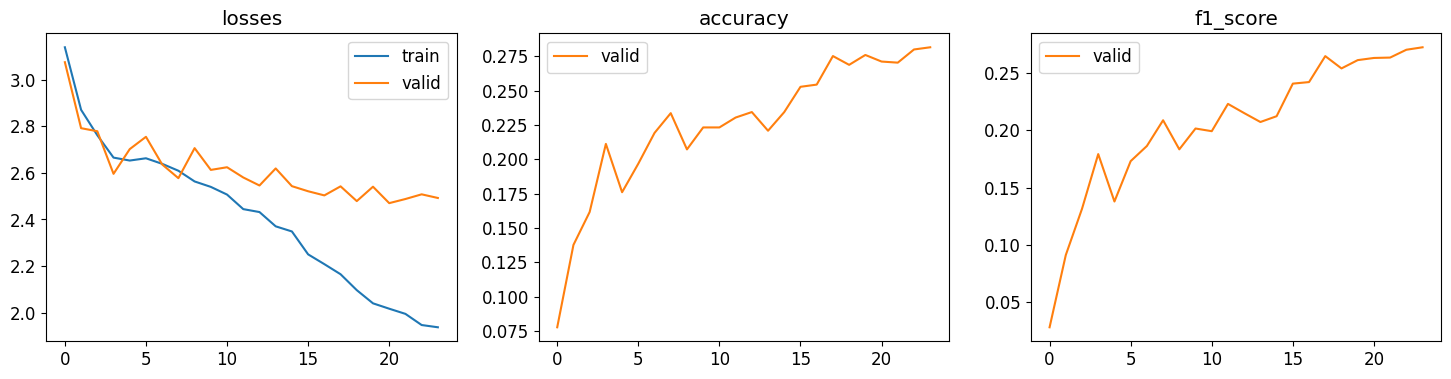

In [27]:
cbs=[SaveModelCallback(), EarlyStoppingCallback(min_delta=0.01, patience=5)]
learn.fit_one_cycle(n_epoch=25, lr_max=lrs.valley,cbs=cbs)
learn.recorder.plot_metrics()

Se puede ver cómo el error de validación se mantiene más o menos estable en las últimas épocas realizadas. Posiblemente emplear unas cuantas épocas más no hubiese servido de mucho ya que se detendría el proceso de entrenamiento por **early_stopping**.

In [ ]:
doc(Recorder)

Hemos usado **recorder**, que registra estadísticas del proceso de entrenamiento, como las tasas de aprendizaje, pérdidas y métricas empleadas (en este caso, accuracy). Además, las métricas se calculan por defecto sobre el conjunto de validación únicamente (`train_metrics=False`, `valid_metrics=True`)

In [28]:
#tomamos la perdida y accuracy obtenida al evaluar el mejor  modelo encontrado sobre el conjunto de validación
val_loss, val_accuracy, val_f1 = learn.validate()
print(f"Pérdida en val: {val_loss}, Accuracy en val: {round(100*val_accuracy, 3)}, F1 en val: {val_f1}")

Pérdida en val: 2.470113515853882, Accuracy en val: 27.12, F1 en val: 0.2630467343151647


Visualizamos resultados evaluando nuestro modelo en unas cuantas imagenes del conjunto de validación.
Por defecto se usa validation set y se seleccionan, de forma aleatoria, 9 imágenes.

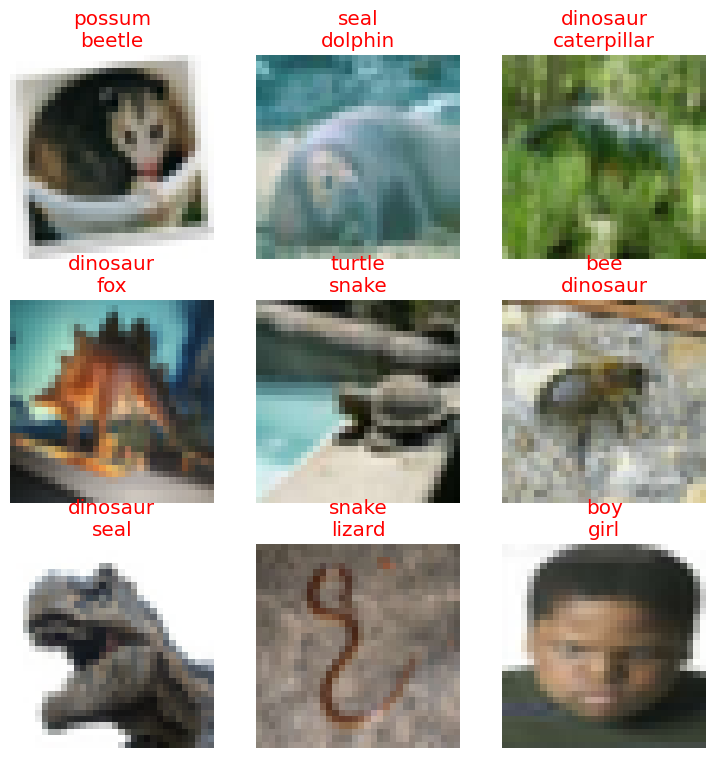

In [29]:
learn.show_results()

Vamos a mostrar la matriz de confusión usando los datos de validación, lo que nos permitirá ver los errores que ha cometido nuestro modelo a la hora de clasificar las diferentes imágenes.

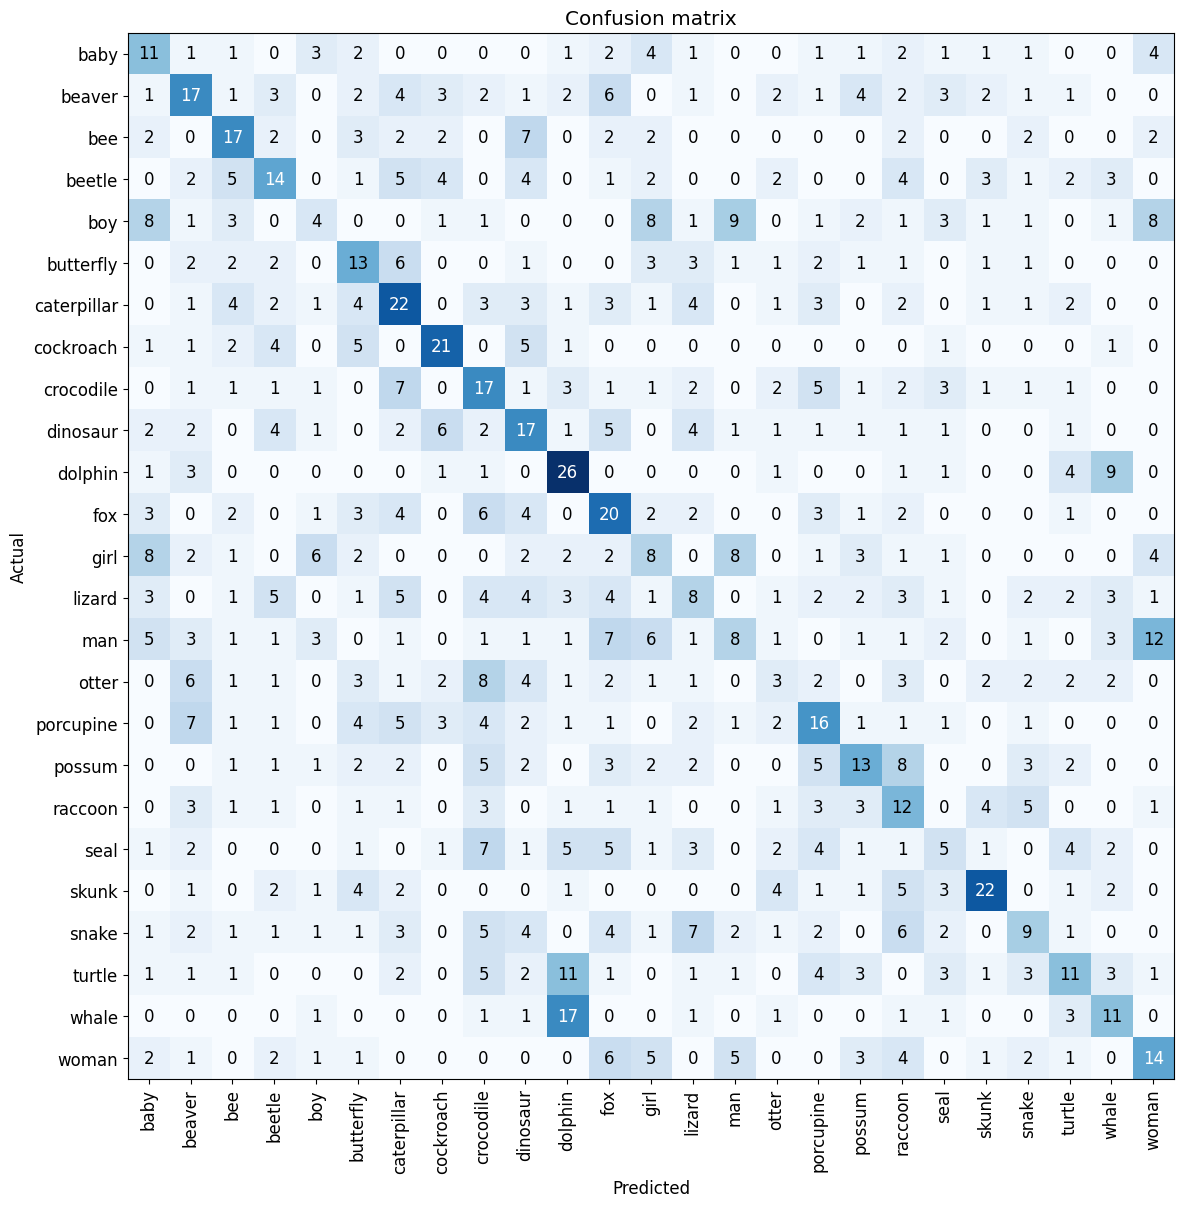

In [30]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12, 12))

La matriz de confusión nos es útil para visualizar dónde se localizan exactamente los errores, permitiéndonos detectar si es debido a problemas en el dataset de trabajo (imágenes defectuosas, mal etiquetadas...) o problemas de nuestro propio modelo (no es capaz de manejar imágenes con brillos especiales, tomadas desde diferentes ángulos...). Vamos a proceder a visualizar las imágenes de mayor a menor pérdida.

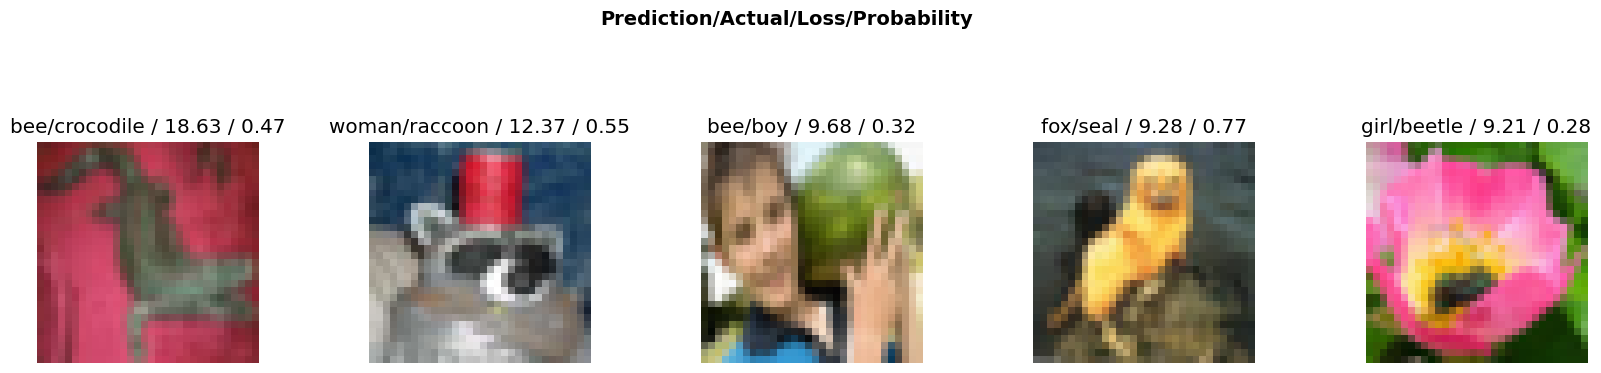

In [31]:
interp.plot_top_losses(5, nrows=1, figsize=(20, 5))
plt.subplots_adjust(wspace=0.5)

Se muestran las 5 imágenes de validación con mayor pérdida, etiquetando cada una de ellas con 4 valores: clase predicha, clase real, pérdida y probabilidad de que pertenezca a la clase predicha.

Una vez entrenado el modelo, lo evaluamos sobre el dataset de test. Comenzamos preparando las imágenes de test antes de ser pasadas al modelo entrenado, especificando que vienen etiquetadas (con intención de evaluar el rendimiento final de nuestro modelo en test). Desactivar el parámetro `with_labels` sería equivalente a predecir sin más la clase de las imágenes usando nuestra versión final del modelo.

In [32]:
#dataloader de test a partir de las imagenes de test
test_dl = learn.dls.test_dl(get_image_files(path/'test'),with_labels=True)

In [ ]:
#doc(TfmdDL.show_batch)

Procedemos a comprobar que se han cargado y preparado correctamente los datos de test, mostrando para ello un lote, por defecto, de 9 muestras, especificando tanto la imagen como la clase a la que pertenece.

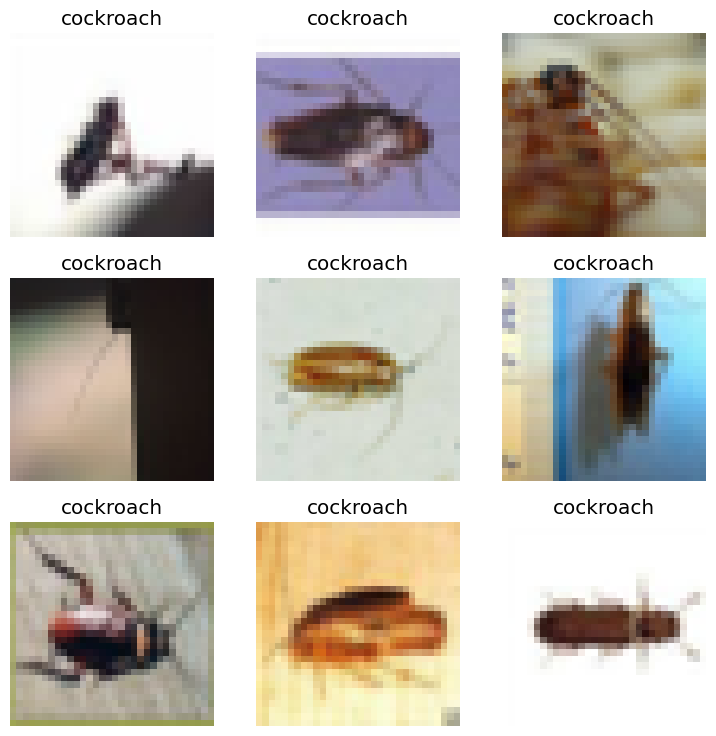

In [33]:
#lote de 9 muestras, por defecto.
test_dl.show_batch()

Obtenemos las predicciones para cada imagen, y las etiquetas reales. Además, activamos el parámetro `with_decoded` para obtener las clases predichas decodificadas (índices de la clase predicha para cada imagen de test).

In [34]:
preds, targs, _ = learn.get_preds(dl=test_dl, with_decoded=True)

In [35]:
print(preds.shape) #matriz (batch,clases)
print(_) #indice de clase predicha para cada imagen de test
print(targs) #indice de clase real para cada imagen de test

torch.Size([2500, 25])
tensor([19, 15, 19,  ..., 11, 11, 11])
tensor([ 7,  7,  7,  ..., 11, 11, 11])


In [36]:
acc = accuracy(preds, targs)
print('The test accuracy is : ', round(float(acc)*100, 4), '%')

The test accuracy is :  28.6 %


Veamos la matriz de confusión evaluada sobre test.

Number of test examples: 2500


Test Accuracy
28.599999999999998


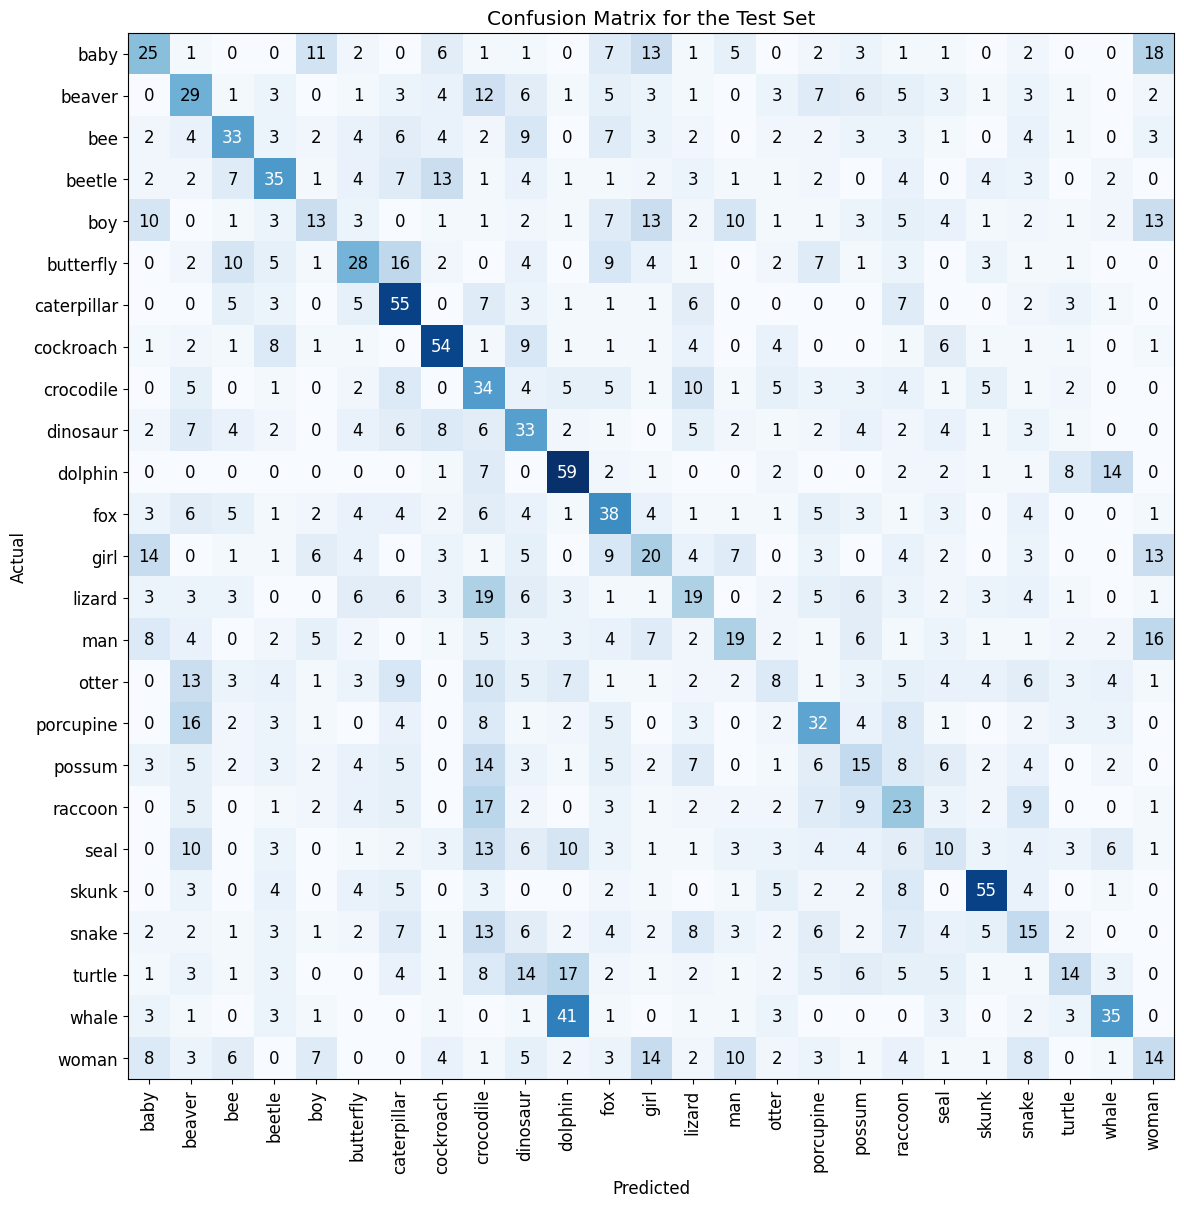

In [37]:
#construimos el objeto interpretable usando el learner
'''
Parámetros requeridos:
* learn: modelo usado para crear la interpretación
* ds_idx: indice de dataloader del learn a usar cuando no se especifica un dl
* dl: DataLoader que se va a usar para hacer predicciones
'''
interp = ClassificationInterpretation.from_learner(learn, 1, test_dl)
#geenramos la matriz de confusión
cm = interp.confusion_matrix()
print('Number of test examples:', np.sum(cm))
interp.plot_confusion_matrix(figsize=(12, 12),title='Confusion Matrix for the Test Set')
print('Test Accuracy')
print(np.sum(np.diagonal(cm))/np.sum(cm)*100)

De igual forma que hicimos sobre validación, procedemos a devolver las 5 imágenes de test con mayor pérdida.

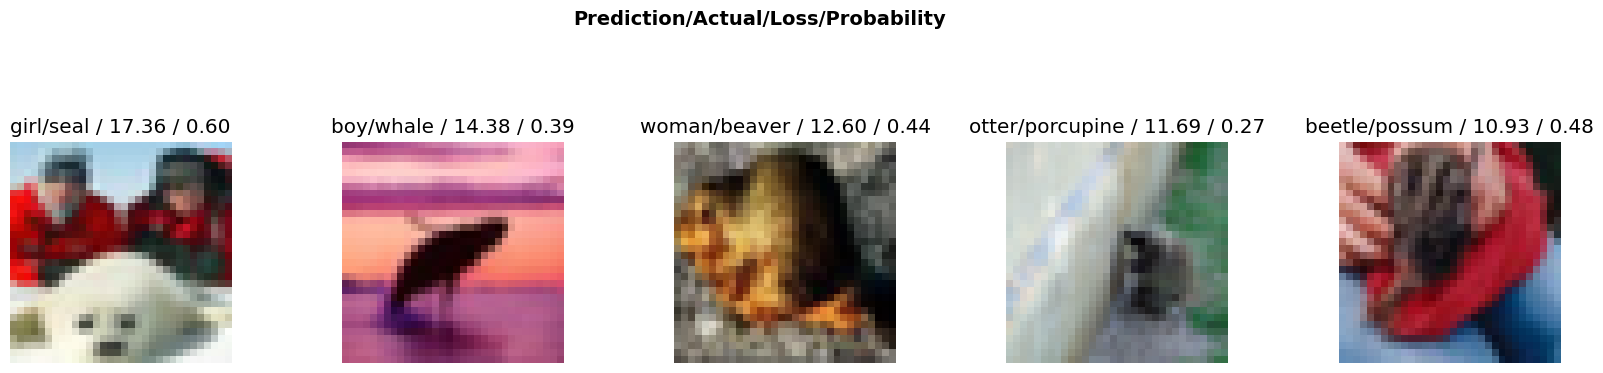

In [38]:
interp.plot_top_losses(5, nrows=1, figsize=(20, 5))
plt.subplots_adjust(wspace=0.5)



---



---



---



# <font color='blue'> **Ejercicio 2:** **Mejoras sobre el modelo BaseNet (4 puntos)**
<font color='blue'>Ahora el objetivo es crear una versión mejorada del modelo _Base Net_ (implementado en el anterior apartado). Para ello, se puede experimentar con distintas funciones de activación, funciones de pérdida, una mayor o menor profundidad de la red, un mayor o menor número de filtros por bloque convolucional, y/o diferentes técnicas de regularización u optimización, entre otras. De hecho, los alumnos deben sentirse libres para experimentar e incorporar todas las modificaciones que consideren pertinentes, incluyendo elementos no vistos ni en teoría ni en prácticas (por ejemplo, componentes que hayan podido descubrir a través de la revisión de artículos científicos). **Se valorará la originalidad y complejidad de la propuesta realizada.**

<font color='blue'>Es necesario destacar que **es imprescindible justificar de la mejor forma posible las decisiones tomadas** (ya sea mediante evidencia empírica o mediante literatura científica), **así como el rendimiento obtenido** (esto es, intentar explicar qué es lo que hace que mejore tanto el rendimiento). También es importante remarcar que **las mejoras introducidas, dentro de lo posible, deben realizarse de forma incremental**, es decir, no basta con crear directamente (de forma mágica) un único modelo y evaluarlo:  **es necesario justificar y describir qué pasos y resultados intermedios nos han llevado a diseñar ese modelo concreto**. Se debe describir cada una de las mejoras incorporadas, así como analizar los resultados obtenidos (del mismo modo que se hizo en el Ejercicio 1, y empleando los mismos criterios de partida; por ejemplo, usando un $10\%$ de los ejemplos de entrenamiento para validación). También es necesario, al igual que en el Ejercicio 1, desglosar el número de parámetros del modelo final, y se debe hacer un `summary()` del modelo para verificar que la arquitectura se ha construido correctamente y que el número de parámetros se corresponde con lo esperado.  

<font color='blue'>Como referencia para los estudiantes, se espera que la _accuracy_ en validación alcance, como mínimo, el $65\%$.


# **1. Data Augmentation**

Como primer paso, procederé a aplicar varias técnicas de data augmentation, con el objetivo de incrementar el tamaño del conjunto de datos de entrenamiento, y que supone crear nuevas imágenes aplicando diferentes transformaciones sobre las imágenes originales.

De hecho,nuestro modelo no sabe cómo se comportan las imágenes, no siendo capaz de reconocer inicialmente que un objeto, por ejemplo, rotado, sigue siendo el mismo objeto. Al fin y al cabo, queremos que nuestro modelo sea capaz de reconocer una misma cosa, independientemente de que esté rotada, situada en otra parte de la imagen, con un mayor contraste...

Procederemos a hacer uso del método `aug_transforms`, cuyos parámetros se corresponden justamente con las trasnformaciones que queremos aplicar sobre los datos de entrenamiento. Es importante indicar que estas transformaciones se aplicarán a nivel de batch (**batch_tfms**). En mi caso, usaré las transformaciones empleadas por defecto:

* **Random flipping**, que voltea de forma aleatoria la imagen. Se corresponde con el siguiente parámetro del método anteriormente comentado:
  - `do_flip` : por defecto a True. Además,la probabilidad de que una imagen se voltee aleatoriamente es de un 50% (`p=0.5`)
* **Rotación aleatoria** de un máximo de `max_rotate` grados
* **Zoom aleatorio** entre `min_zoom=1.0` (por defecto no podemos alejarnos de la imagen) y `max_zoom=1.1` (podemos escalar la imagen como mucho un 110% de su tamaño original).
* **Deformación de perspectiva** con una deformación máxima de un 20% (`max_warp=0.2`)

  Esas tres ultimas transformaciones se corresponden con aplicaciones afines. En este caso, la probabilidad de que se aplique una transformación afín sobre una imagen (ya sea una rotación, zoom o deformación) es de un 75%, medido por `p_affine=0.75`

* **Cambio de brillo y contraste**, con una escala máxima de cambio del 20% (`max_lighting=0.2`). La probabilidad de que se aplique uno de estas últimas dos transformaciones viene dada por el parámetro `p_lightint=0.75`, es decir, 75% de probabilidad.


Otros parámetros relevantes a comentar de dicho método son los siguientes:

* ` mult` : nos permite incrementar o decrementar la varianza a introducir sobre los datos de entrenamiento, multiplicando dicho valor por `max_rotate`, `max_lighting` y `max_warp`, lo que podría implicar rotar un mayor nº de grados, realizar cambios de brillo y contraste más severos y aplicar deformaciones de perspectiva más notorias. Dejamos el valor por defecto, 1.

* `size` : tamaño final de las imagenes tras aplicar las transformaciones. En este caso, usaremos `size=32`, para asegurarnos de seguir trabajando con imágenes 32x32.

* `mode` : método de interpolación empleado para redimensionar la imagen. Por defecto, se usa **interpolación bilineal**.

* `pad_mode` : modo de relleno, es decir, cómo se rellenan las áreas vacías creadas por transformaciones que afectan a la geometría de la imagen, como rotaciones, warps o traslaciones. Por defecto se emplea **reflection**, reflejando los píxeles de la imagen alrededor de los bordes.

In [ ]:
#doc(aug_transforms)



---



Otra **técnica de data aumentation** que emplearemos será el uso de `RandomResizedCrop`. Básicamente, se encarga de recortar una porción aleatoria de la imagen y redimensionarla al tamaño especificado. Este proceso se realiza para cada época y sobre todas las imágenes del dataset, de tal forma que el recorte realizado sobre cada imagen variará en función de la época. Los parámetros a especificar son los siguientes:
* `size` : tamaño que queremos que tenga la porción de la imagen recortada. En nuestro caso, como estamos trabajando con imágenes 32x32, usaremos `size=32`
* `min_scale` : mínima escala del recorte, en relación al área de la imagen. En otras palabras, cuánto de la imagen tenemos que seleccionar, como mínimo.Yo me decantaré por un 40%, es decir, que el recorte ocupe como mínimo un 40% de la imagen original.
* `resamples` : este parámetro hace referencia al modo de remuestreo, es decir, el método empleado para redimensionar al tamaño indicado la porción de la imagen que se ha recortado de forma aleatoria. Dejaremos el valor por defecto, que equivale a emplear **interpolación bilineal**.

Tras esto, probamos si ha habido alguna mejora en nuestro modelo, añadiendo las técnicas comentadas al datablock definidido inicialmente.

In [39]:
'''
Comenzamos empleando aug_aumentation y RandomResizedCrop, reciclando la definición inicial del datablock,
pero añadiendo las técnicas especificadas.
'''
dblock=dblock.new(item_tfms=RandomResizedCrop(size=32,min_scale=0.4),batch_tfms=aug_transforms(size=32))

Procedemos ahora a preparar los datos de training y val usando el nuevo datablock.


In [40]:
dls=dblock.dataloaders(path/'train',bs=64,drop_last=False)
dls.train.sampler = RandomSampler(dls.train.dataset,generator=gen)

In [41]:
print('Numero de ejemplos de entrenamiento (una vez descartados los de validacion):', len(dls.train_ds))
print('Numero de ejemplos de validacion:', len(dls.valid_ds))
print("Nº de lotes de entrenamiento : ",len(dls.train))
print("Nº de lotes de validación : ",len(dls.valid))

Numero de ejemplos de entrenamiento (una vez descartados los de validacion): 11250
Numero de ejemplos de validacion: 1250
Nº de lotes de entrenamiento :  176
Nº de lotes de validación :  20


Podemos ver cómo el nº de lotes que se generan sigue siendo el mismo que sin aplicar `aug_transforms`, es decir: no estamos directamente ampliando el dataset inicial generando copias alteradas de los datos (lo que podría aumentar el riesgo de sobreajuste), sino que al momento de pasar una imagen al modelo, se le entregará la imagen original o la imagen afectada por una transformación o secuencia de transformaciones.

Vamos a visualizar los efectos de las técnicas comentadas aplicadas sobre una misma imagen, obteniendo diferentes versiones de una misma imagen que se obtienen recortando aleatoriamente una parte de la imagen original y luego aplicandole diferentes transformaciones (aug_transforms).

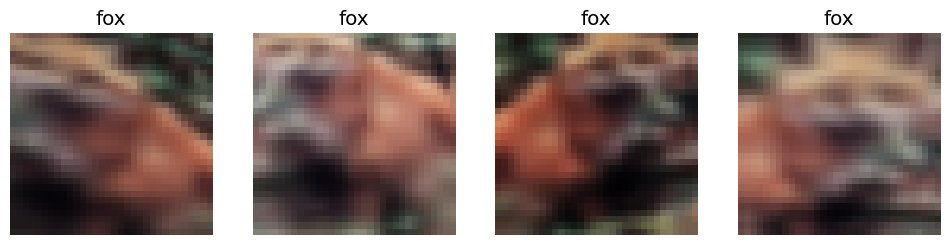

In [42]:
#unique=True nos permite devolver diferentes versiones de una misma imagen
dls.train.show_batch(max_n=4, nrows=1, unique=True)

In [43]:
learn = Learner(dls, get_model(), metrics=[accuracy,F1Score(average='weighted')],
                loss_func=CrossEntropyLossFlat(),  #new loss-function
                opt_func=Adam)

Tras definir el objeto de aprendizaje, procedemos a calcular nuevamente la **tasa de aprendizaje óptima** antes de entrenar el modelo usando `fit_one_cycle`

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

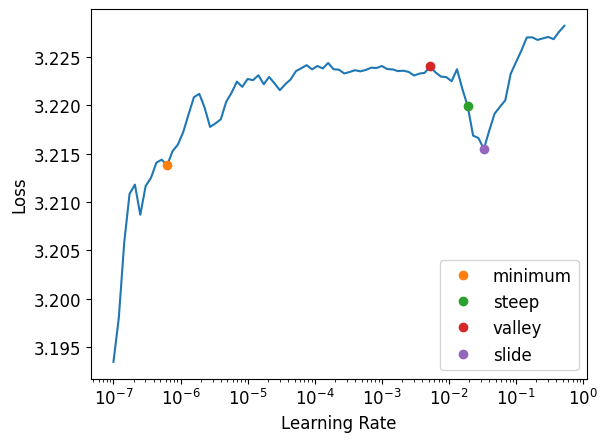

In [44]:
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [45]:
print(f"Tasa de aprendizaje óptima escogida : {round(lrs.valley,5)}")

Tasa de aprendizaje óptima escogida : 0.00525


Tras ello, entrenamos el modelo.

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,3.185719,3.133704,0.070400,0.022569,00:20
1,3.022040,2.989657,0.092000,0.041209,00:18
2,2.978089,2.958209,0.104000,0.048281,00:18
3,2.890873,2.788452,0.152800,0.100495,00:18
4,2.821137,2.739100,0.150400,0.116427,00:18
5,2.783371,2.685176,0.174400,0.133064,00:18
6,2.740496,2.665219,0.186400,0.145866,00:19
7,2.701637,2.618372,0.199200,0.162874,00:20
8,2.676977,2.610775,0.201600,0.163022,00:18
9,2.661281,2.657763,0.216000,0.184688,00:18


Better model found at epoch 0 with valid_loss value: 3.133704423904419.
Better model found at epoch 1 with valid_loss value: 2.989656686782837.
Better model found at epoch 2 with valid_loss value: 2.9582087993621826.
Better model found at epoch 3 with valid_loss value: 2.788451671600342.
Better model found at epoch 4 with valid_loss value: 2.7390997409820557.
Better model found at epoch 5 with valid_loss value: 2.685175895690918.
Better model found at epoch 6 with valid_loss value: 2.665219306945801.
Better model found at epoch 7 with valid_loss value: 2.6183719635009766.
Better model found at epoch 8 with valid_loss value: 2.610774517059326.
Better model found at epoch 10 with valid_loss value: 2.512486219406128.
Better model found at epoch 13 with valid_loss value: 2.485161066055298.
Better model found at epoch 15 with valid_loss value: 2.469822645187378.
Better model found at epoch 17 with valid_loss value: 2.45037579536438.
Better model found at epoch 18 with valid_loss value: 2.43

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

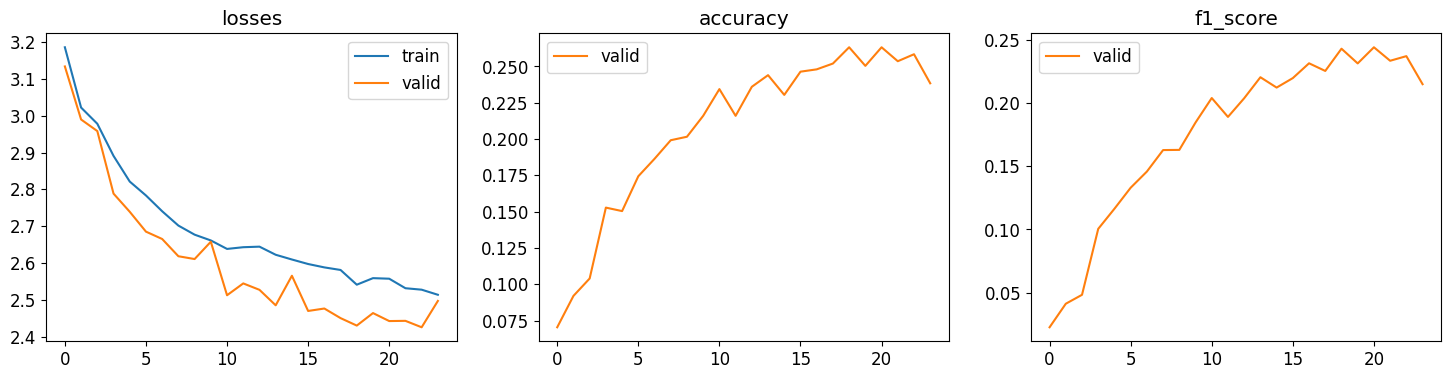

In [46]:
cbs=[SaveModelCallback(), EarlyStoppingCallback(min_delta=0.01, patience=5)]
learn.fit_one_cycle(n_epoch=50, lr_max=lrs.valley,cbs=cbs)
learn.recorder.plot_metrics()

In [48]:
#tomamos la perdida y accuracy obtenida al evaluar el mejor  modelo encontrado sobre el conjunto de validación
val_loss, val_accuracy, val_f1 = learn.validate()
print(f"Pérdida en val: {val_loss}, Accuracy en val: {round(100*val_accuracy, 3)}, F1 en val: {val_f1}")

Pérdida en val: 2.425523519515991, Accuracy en val: 25.84, F1 en val: 0.23723873625087993


Nuestro modelo no ha conseguido una mejora aplicando las técnicas comentadas de Data Augmentation. Sin embargo, voy a mantener los cambios realizados hasta ahora, ya que considero que mi modelo no está aún aprovechando completamente las variaciones introducidas, debido a que es un modelo muy simple, el cual requiere de modificaciones extras que incrementen la complejidad del modelo, y dando posiblemente lugar a un mejor aprovechamiento de las técnicas comentadas inicialmente.

# **2. Normalización**

Optaremos por normalizar las características o atributos de entrada, que en el caso de trabajar con imágenes, se corresponden con los niveles de rojo, verde y azul que emplea dicha imagen (cada canal representa una característica o atributo). A la hora de pasarle a nuestro modelo un lote de imágenes, se normalizará, por separado, los niveles de verde de las imágenes del lote, niveles de rojo y niveles de azul.

 Este proceso de normalización permitirá a nuestro modelo a trabajar con datos de media 0 y desviación típica 1 (distribución normal estándar).

Vamos a comprobar primeramente cómo la media y desviación no se corresponden a los valores deseados, para cada canal, y trabajando con las imágenes de un mismo lote.

In [49]:
#generamos un lote de muestras (imagen,clase), tomando por una parte el tensor con las imágenes, y por otra parte, las clases asociadas
x, y = dls.one_batch()
#usando 'x', tensor con las imágenes, calculamos la media y desviación típica, para cada canal
x.mean(dim=[0,2,3]),x.std(dim=[0,2,3])

(TensorImage([0.4864, 0.4784, 0.4451], device='cuda:0'),
 TensorImage([0.2485, 0.2370, 0.2458], device='cuda:0'))

Como se puede apreciar, las medias y desviaciones no se aproximan lo suficiente a los valores deseados (media 0 y desviación típica 1). Para llevar a cabo este proceso de normalización, empleareamos la transformación a nivel de batch `Normalize.from_stats(mean,std)`, siendo necesario pasar como parámetros tanto la media como la desviación a emplear para normalizar : $$
X_{\text{normalizado}} = \frac{X - \mu}{\sigma}$$

Es importante indicar que la media y desviación empleadas se corresponden justamente con las definidas en Imagenet (subconjunto del dataset ImageNet) :

 `imagenet_stats` : **([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])**

 Se indica la media y desviación de cada canal (en este caso, RGB).

 Si no se especifica nada al usar el método `Normalize()`, fastai calculará automáticamente la media y desviación típica a usar sobre un único lote, y por cada canal.

Modificamos el último DataBlock definido, agregando esta nueva transformación a nivel de batch.

In [50]:
from fastai.vision.all import imagenet_stats
# Normalización basada en las estadísticas de ImageNet
#especificamos las transformaciones a nivel de batch que se van a aplicar, añadiendo el 'Normalize'
dblock = dblock.new(batch_tfms=[*aug_transforms(size=32), Normalize.from_stats(*imagenet_stats)])
dblock.summary(path/'train')

Setting-up type transforms pipelines
Found 12500 items
2 datasets of sizes 11250,1250
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/cifar100/train/medium_mammals/fox/red_fox_s_000037.png
    applying PILBase.create gives
      PILImage mode=RGB size=32x32
  Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /root/.fastai/data/cifar100/train/medium_mammals/fox/red_fox_s_000037.png
    applying parent_label gives
      fox
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(11)

Final sample: (PILImage mode=RGB size=32x32, TensorCategory(11))


Found 12500 items
2 datasets of sizes 11250,1250
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': Tru

Esta normalización de los datos de entrada (lote de imágenes) ayuda al modelo a aprender los pesos adecuados para cada atributo, ya que sin este ajuste previo, el modelo prestará demasiado atención a los atributos con rangos amplios, dando menor importancia a aquellos con rangos estrechos. Esto es debido a que al calcular el gradiente, el gradiente de las características más grandes serán mucho mayores que los de las pequeñas, dando lugar a que algunos pesos sufran una actualización más severa que otros (en este caso, los pesos asociados a los atributos más grandes). Además, permite una convergencia del modelo más rápida, ya que trabajar con atributos que tengan diferentes rangos puede provocar rebotes del descenso de gradiente y ralentizar la convergencia hacia el punto del espacio paramétrico óptimo.

Es importante indicar que normalizar los atributos durante el entrenamiento obliga también a normalizarlos a la hora de realizar predicciones, ya que nuestro modelo ha aprendido a trabajar con atributos que siguen una misma distribución normal con $μ=0$ y $σ=1$.

Procedemos a preparar los datos de trabajo usando el nuevo datablock definido (incluye normalización).

In [51]:
dls=dblock.dataloaders(path/'train',bs=64,drop_last=False)
dls.train.sampler = RandomSampler(dls.train.dataset,generator=gen)

Generamos un lote de imágenes para calcular la media y desviación típica de cada canal, observando como efectivamente, ahora las medias y desviaciones son próximas a 0 y 1, respectivamente, tal y como buscábamos.

In [52]:
x, y = dls.one_batch()
#usando 'x', tensor con las imágenes, calculamos la media y desviación típica, para cada canal
x.mean(dim=[0,2,3]),x.std(dim=[0,2,3])

(TensorImage([-0.0489,  0.0053,  0.0008], device='cuda:0'),
 TensorImage([1.1223, 1.0435, 1.1265], device='cuda:0'))

---



---



---

# **3. Batch Normalization**

Implica básicamente **normalizar**, no los atributos de entrada al modelo (que es justo lo que hemos realizado en el paso previo), sino las **activaciones de cada una de las capas ocultas de la red**, con el objetivo de buscar las mismas ventajas que nos ofrecía la normalización de los atributos de entrada de la primera capa. Solventa el problema de **internal covariate shift**, que hace referencia a los cambios de distribución de las salidas de las capas ocultas de la red profunda (debido al cambio de los parámetros).

Batch Norm es una capa más de nuestra red, insertada entre dos capas ocultas adyacentes, normalizando las salidas de la primera capa oculta antes de pasárselas como entradas a la siguiente capa oculta.

Al igual que cualquier otra capa del modelo empleado, Batch Norm también emplea una serie de parámetros a aprender: $γ$ y $β$. Además, se hace uso de una serie de conceptos conocidos como **media móvil ponderada y varianza móvil ponderada**, que más adelante comentaré.

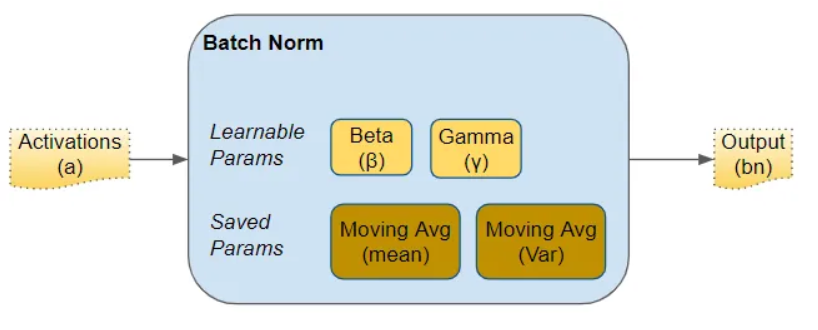

Durante el entrenamiento de la red, Batch Norm recibirá un lote de muestras con ciertas características, que representan las salidas de una cierta capa oculta. El proceso interno que se lleva a cabo es el siguiente:

1. Se **calcula la media y desviación típica** para cada una de las características y considerando todas las muestras.
2. **Normalización** (con media 0 y desviación 1) para cada característica, empleando la media y desviación asociadas, calculadas previamente. Se considera un cierto $ϵ>0$ para evitar dividir entre 0 cuando $σ=0$.

$$\hat{x}_i = \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}}$$

3. A diferencia del proceso de normalización usual, Batch Norm nos permite trabajar con distribuciones normales que no tienen por qué tener $μ=0$ y $σ=1$ (diferentes de la estándar) : nos permite desplazar y escalar los valores normalizados, dando lugar a que tengan medias y variaciones diferentes a las de la distribución normal estándar. Esto se consigue de la siguiente forma:

$$y_i = \gamma \hat{x}_i + \beta$$

4. Se actualiza tanto la media como desviación móvil ponderadas, empleando la nueva media y desviación típica calculadas, ponderando estos últimos valores usando un hiperparámetro denotado con $α$ (**momentum**).

$$\mu_{\text{mov_i}} = \text{momentum} \cdot \mu_{\text{mov_i}} + (1 - \text{momentum}) \cdot \mu_{\text{i}}$$


$$\sigma_{\text{mov_i}} = \text{momentum} \cdot \sigma_{\text{mov_i}} + (1 - \text{momentum}) \cdot \sigma_{\text{i}}$$

Estos dos parámetors no aprendidos no se emplean durante la fase de entrenamiento, sino en la fase de predicción.

Es importante indicar que como el parámetro $β$ empleado en batch normalization ya se encarga de desplazar las activaciones, podemos eliminar los bias que emplea la primera de las capas adyacentes entre las que estamos utilizando batch normalization, reduciendo por tanto el nº de parámetros de esa primera capa oculta.

A la hora de inferir, pasaremos al modelo una sola muestra, y no un lote. Al no alimentar dicho modelo con un lote sobre el que podamos calcular su media y varianza (para batch norm), procedemos a usar como  media y desviación típica la media y desviación móvil ponderada.

Durante la fase de entrenamiento, podríamos haber calculado la media y desviación sobre todos los datos de trabajo, pero eso implicaría mantener en memoria una cantidad excesiva de valores. Por ende, usaremos como aproximación a dicha media y desviación del dataset, las medias y desviaciones móviles ponderdas calculadas durante el proceso de entrenamiento.

**¿Cuá es el mejor sitio en el que colocar la capa Batch Norm?**

Dicha capa se debe colocar antes o después de la activación de la capa oculta. En mi caso, procedo a colocarla antes de la activación.

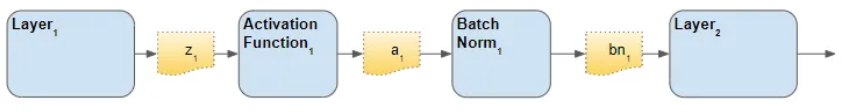

**Aplicación de Batch Normalization sobre mi modelo BaseNet**

Para colocar capas BatchNorm simplemente empleo `BatchNorm2d()`, con los siguientes parámetros:
* `num_features` : nº de características (o canales) en la entrada de la capa. Debe coincidir con el nº de canales de la imagen que devuelve la anterior capa de convolución.
* `eps` : valor de $ϵ$ empleado al normalizar, para evitar dividir entre 0. Por defecto se usa $ϵ=1e−5$.
* `momentum` : hiperparámetro $α$, que se corresponde con la tasa de actualización de las medias y desviaciones móviles. Por defecto, $\alpha=0.1$.

In [ ]:
doc(nn.BatchNorm2d)

Sin embargo, y tras investigar un poco, he observado que fastai me proporciona el método `ConvLayer()`, que me ofrece la posibilidad de crear una capa convolucional junto junto con su correspondiente función de activación, e incluso añadiendo (en el caso de que se indique) BatchNorm, todo ello del tirón. Los parámetros solicitados son los siguientes:
* `ni` : nº de canales de la imagen de entrada
* `nf` : nº de canales de la imagen de salida
* `ks` : tamaño del kernel. Por defecto, **ks=3**
* `stride` : desplazamiento del kernel. Por defecto, **stride=1**
* `padding` : padding a emplear. Si no se especifica, se usará **(ks-1)//2**, que equivale a añadir el padding necesario para que el kernel encaje perfectamente en la imagen y poder desplazarse sobre cada uno de los píxeles de la imagen original. Esto implicará que la reducción de la imagen vendrá determinada únicamente por el stride empleado.
* `bias` : si se emplea BatchNormalization, se pondrá a **False** automáticamente (se eliminan los bias empleados en dicha capa).
* `act_cls` : función de activación. Por defecto, se usará ReLU
* `norm_type` : tipo de normalización a aplicar. Por defecto, se usa **NormType.Batch** (BatchNormalization estándar).

Es importante indicar que si indicamos el uso de BatchNorm, este método creará una capa BatchNorm usando los valores por defecto de los parámetros comentados anteriormente del método **BatchNorm2d()**. Además, por defecto, se aplicará BatchNorm tras la capa convolucional, y antes de la activación. Más adelante comprobaremos esto comentado, tras definir nuestro nuevo modelo.

Redefinimos el modelo inicial introduciendo Batch Normalization, y ayudándonos del método comentado : **ConvLayer()**

Indicar que se empleará ReLU como función de activación, descartando las activaciones iniciales empleadas como la tangencial o la sigmoide.

In [53]:
def get_model():
  return sequential(
    ConvLayer(3,5,ks=9,padding=0), #conv+batch_norm+ReLU
    nn.MaxPool2d(kernel_size=2,stride=2),
    ConvLayer(5,10,ks=7,padding=0),
    nn.Flatten(), #salida:6x6x10
    nn.Linear(10 * 6 * 6, 50),
    nn.ReLU(),
    nn.Linear(50, 25)
  )
get_model()

Sequential(
  (0): ConvLayer(
    (0): Conv2d(3, 5, kernel_size=(9, 9), stride=(1, 1), bias=False)
    (1): BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): ConvLayer(
    (0): Conv2d(5, 10, kernel_size=(7, 7), stride=(1, 1), bias=False)
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=360, out_features=50, bias=True)
  (5): ReLU()
  (6): Linear(in_features=50, out_features=25, bias=True)
)

Tal y como se puede apreciar, se empleará BatchNormalization tras cada convolución y antes de la activación, empleando los valores por defecto, tal y como se comentó.

Ya tenemos nuestro nuevo modelo correctamente definido.Probemos a entrenarlo,siguiendo el mismo procedimiento realizado en pasos previos.

In [54]:
learn = Learner(dls, get_model(), metrics=[accuracy,F1Score(average='weighted')],
                loss_func=CrossEntropyLossFlat(),  #new loss-function
                opt_func=Adam)

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

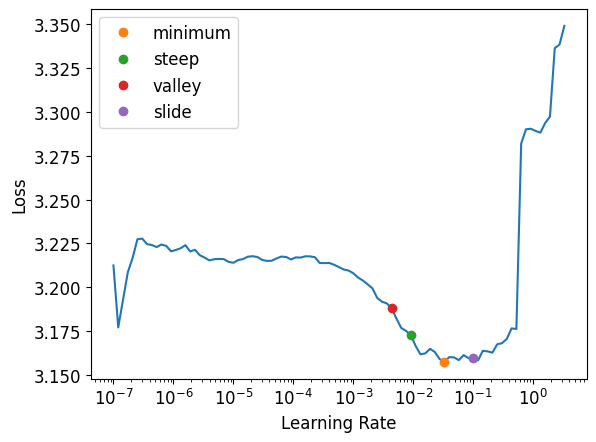

In [55]:
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [56]:
print(f"Tasa de aprendizaje óptima escogida : {round(lrs.valley,5)}")

Tasa de aprendizaje óptima escogida : 0.00437


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,3.021981,3.002631,0.105600,0.069885,00:22
1,2.867793,2.824189,0.162400,0.122419,00:15
2,2.692670,2.645876,0.179200,0.143575,00:15
3,2.591690,2.537844,0.227200,0.186697,00:15
4,2.549766,2.501100,0.226400,0.197697,00:15
5,2.541763,2.516191,0.225600,0.195012,00:15
6,2.507324,2.449081,0.248000,0.220002,00:15
7,2.479880,2.422737,0.266400,0.241342,00:15
8,2.465868,2.462955,0.263200,0.236049,00:15
9,2.445061,2.435317,0.257600,0.235916,00:15


Better model found at epoch 0 with valid_loss value: 3.002631187438965.
Better model found at epoch 1 with valid_loss value: 2.824188709259033.
Better model found at epoch 2 with valid_loss value: 2.6458756923675537.
Better model found at epoch 3 with valid_loss value: 2.537843704223633.
Better model found at epoch 4 with valid_loss value: 2.5011003017425537.
Better model found at epoch 6 with valid_loss value: 2.4490809440612793.
Better model found at epoch 7 with valid_loss value: 2.4227373600006104.
Better model found at epoch 10 with valid_loss value: 2.406744956970215.
Better model found at epoch 11 with valid_loss value: 2.389960289001465.
Better model found at epoch 12 with valid_loss value: 2.3635311126708984.
Better model found at epoch 13 with valid_loss value: 2.349252462387085.
Better model found at epoch 14 with valid_loss value: 2.305793046951294.
Better model found at epoch 18 with valid_loss value: 2.28775691986084.
Better model found at epoch 19 with valid_loss value: 

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

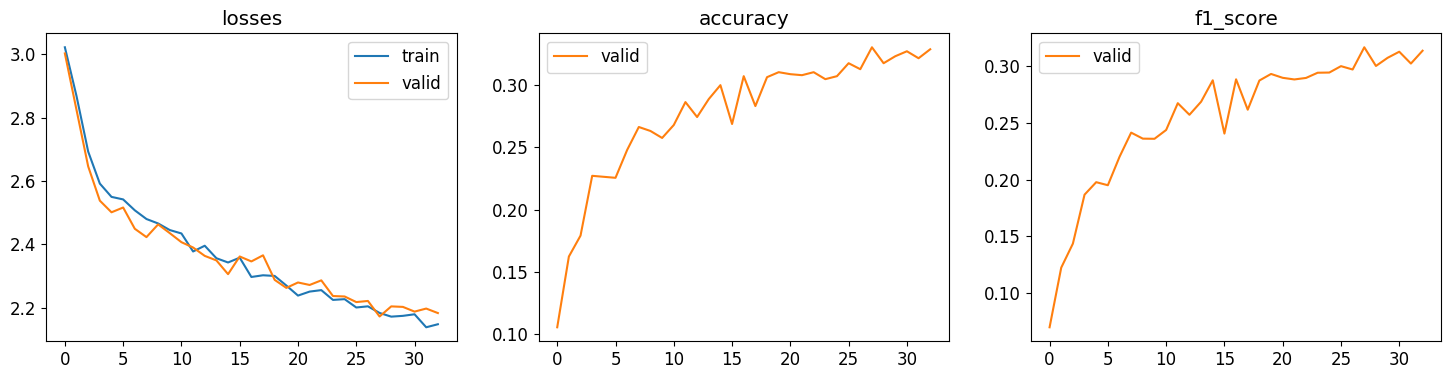

In [57]:
cbs=[SaveModelCallback(), EarlyStoppingCallback(min_delta=0.01, patience=5)]
learn.fit_one_cycle(n_epoch=50, lr_max=lrs.valley,cbs=cbs)
learn.recorder.plot_metrics()

In [58]:
val_loss, val_accuracy, val_f1 = learn.validate()
print(f"Pérdida en val: {val_loss}, Accuracy en val: {round(100*val_accuracy, 3)}, F1 en val: {val_f1}")

Pérdida en val: 2.1722350120544434, Accuracy en val: 33.04, F1 en val: 0.31652728884518044




---



# **4. Weight decay**

L2 Reguralization y Weight Decay son técnicas que aplican penalizaciones muy similares, aunque en función del optimizador empleado pueden ser o no equivalentes.

* **L2 Regularization** consiste en añadir la suma del cuadrado de los pesos a la función de pérdida (todo ello multiplicado por la tasa de regularización), redefiniendo por tanto la función de pérdida.

$$\text{Loss} = \text{Loss original} + \lambda \cdot \sum_{i} w_i^2$$

* **Weight decay** consiste en introducir esa penalización directamente al actualizar los pesos durante el entrenamiento, no viéndose afectada por ende la función de pérdida que optimiza el algoritmo de optimización correspondiente.

$$\text{new_weight} = \text{weight} - \eta \cdot \nabla L - \eta \cdot \lambda \cdot \text{weight}$$



En caso de emplear SGD, ambas fórmulas son equivalentes (L2 regularization idéntico a weight decay).

Sin embargo, no ocurre lo mismo con Adam, ya que el proceso de actualización implica una serie de cálculos adicionales sobre el gradiente. Somos libres de escoger cualquiera de las dos técnicas comentadas, aunque existen una serie de artículos científicos en los que se demuestra que es más correcto emplear **Weight decay**, separando la penalización empleada de los pasos de optimización que se toman con respecto a la función de pérdida, sin verse afectado el rendimiento del optimizador empleado.

El optimizador Adam que nos proporciona fastai dispone de un parámetro que nos permite controlar justamente lo indicado:
* `decouple_wd` :
  * Si es **True**, se emplea weight decay (**AdamW**)
  * Si es **False**, se emplea L2 Regularization
  * Por defecto, `decouple_wd = True`


Esto es, fastai ya emplea por defecto AdamW. Por ende, para terminar aplicando esta técnica, tendremos que especificar el siguiente parámetro al definir nuestro objeto de la clase Learner:
* `wd` : tasa de regularización. Por defecto, no tiene asignado ningún valor, por lo que no se penaliza de ninguna forma los pesos del modelo. En mi caso, emplearé `wd=0.001`

También es posible especificar la tasa de regularización al entrenar nuestro modelo con `fit_one_cycle`, aunque optaré por especificarla al definir el learner.




---



# 5. Residual blocks

Tras todas estas mejoras, podemos ver que no hemos obtenido una mejora realmente notable. Esto es debido a la simplicidad de nuestro modelo, el cual emplea únicamente dos convoluciones. Por tanto, mi idea es probar a añadir unas cuantas capas convolucionales más, aumentado así la complejidad de mi modelo, con esperanzas de obtener mejoras considerables que nos permitan lograr una accuracy en validación mucho más alta. Sin embargo, no añadiremos capas convolucionales sin más (sin definir ninguna relación entre ellas), sino que haremos uso de bloques residuales.

La idea de todo esto es la siguiente:
* Tras ciertos experimentos realizados y comentados en artículos científicos, se ha visto que **aumentar la profundidad de redes planas**, añadiendo capas convolucionales sin más, suele producir un **empeoramiento del error de training**, haciendo que un modelo inicial de 20 capas pueda ser mejor que uno de 56, obtenido a partir del inicial y añadiendo capas de convolución sin más, definiendo una red mucho más profunda.

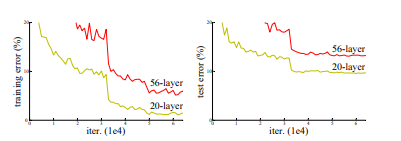

* Una solución que se propone a la hora de aumentar la profundidad de una red es añadir capas no lineales que aplican la función identidad, es decir, capas que devuelven el mismo valor de entrada que recibieron, pero que disponen de una serie de parámetros entrenables en caso de que se considere más óptimo el hecho de que dichas capas aprendan funciones diferentes a la identidad. Esta solución inicial nos permite justamente evitar lo comentando anteriormente: ahora nuestro nueva red (más profunda) será, como mínimo, igual de buena que la red superficial de la que partimos.

Una forma de implementar esto último es definiendo las conexiones de salto. La idea es la siguiente: fijamos una pila de capas dentro de nuestro modelo. En lugar de que aprendan una determinada función $H(x)$ (función aprendida por ese bloque de capas), donde $x$ es justamente el valor de entrada de la primera capa de esa pila, vamos a forzar a que aprendan el residuo entre la salida y la entrada asociada:

$$F(x) = H(x) - x$$

Esto nos permite expresar la función original de la siguiente forma:

$$H(x) = F(x) + x$$

Será mucho más sencillo optimizar la función residuo $F(x)$ que la función original $H(x)$. Esto permitiría lo siguiente: si se encuentra que lo óptimo es aprender la función identidad, es decir, $H(x)=x$, resultaría más sencillo optimizar $F(x)$ (función residuo) para que tienda a 0, en lugar de ajustar esa serie de capas no lineales apiladas para que aprendan la identidad. Por ende, en caso de usar la función residuo, si lo óptimo es emplear la identidad, el optimizador simplemente tendría que hacer que los pesos de las diferentes capas no lineales valgan 0, haciendo que $F(x)=0$, y por ende, $H(x)=x$.

Para poder definir esa nueva función $F(x) + x$, necesitamos hacer uso de las conexiones de salto, que implica hacer que el valor de entrada a dicha pila de capas se salte esas capas y se añada a la salida de esta serie de capas apiladas. Además, esta forma de implementar conexiones de salto aplicando la identidad no suponen un incremento de la complejidad computacional ni del uso de parámetros extra.

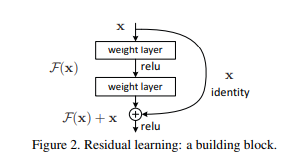

Denominaremos, por tanto, bloque residual, al bloque conformado por una serie de capas no lineales, que devuelve como salida:  la **salida tras aplicar las capas** que lo integran + **valor de entrada a la primera de las capas** del bloque.

**Mejoras con respecto a una red plana (equivalente a introducir capas convolucionales sin más).**

Una de las ventajas que nos ofrecen las redes residuales (redes que emplean bloques residuales) es justamente el hecho de que aumentar su profundidad reflejará mejoras en el modelo, a diferencia de las redes planas, donde emplear un mayor nº de capas conlleva pérdidas.

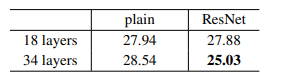

La tabla previa muestra el error de validación tras entrenar sobre ImageNet dos redes idénticas (una plana y otra residual), ambas con el mismo nº de parámetros. Ambas redes tienen la misma estructura, con la única diferencia de que la red residual implementa conexiones de atajo por cada pareja de convoluciones.

Tal y como se puede apreciar, el error de validación de la red plana de 34 capas es más alto que el error de la red plana superficial (sobre la que se ha montado esa red más profunda de 34 capas) de 18 capas. En resumen, tras hacer más profunda esa red plana inicial, el modelo empeora, a pesar de que el espacio de soluciones de la red plana de 18 capas sea un subespacio del correspondiente para la red más profunda.

También se puede ver como la red residual de 34 capas logra un mayor rendimiento que la red plana que emplea el mismo nº de capas, reduciendo un 3.51% el error de validación. Además, incrementar el nº de capas de la red residual nos ha permitido reducir un 2.8% el error de la red residual superficial.

Por último, y no menos importante, a pesar de que ambas redes superficiales (plana y residual de 18 capas) tengan inicialmente un mismo rendimiento, tras incrementar la profundidad de ambas, la red residual es la única que logra realmente mejorar su comportamiento.

**Estructura común de un bloque residual**

Normalmente se emplean bloques residuales formados por dos o tres capas convolucionales, aunque se puede emplear un mayor nº de capas sin problemas. Las capas de convolución que integran estos bloques suelen emplear filtros 3x3, siguiendo las siguientes reglas:
* Si se mantiene la dimensión espacial (filas y columnas de la imagen), se mantiene el nº de canales (nº canales de salida = nº canales de entrada).
* Si se reduce la dimensión espacial, se contrarresta aumentando el nº de canales de salida.
* Para llevar a cabo reducciones espaciales (reducir tamaño de una imagen), se emplean convoluciones 1x1, con stride=2 en caso de reducir ambas dimensiones a la mitad.

A la hora de implementar un bloque residual de dos capas convolucionales, se realizará la suma justo antes de emplear la función de activación de la segunda capa convolucional.

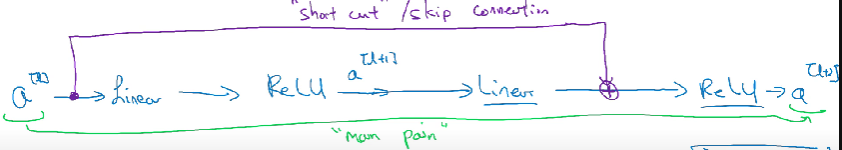

**Implementación de la red residual**

Modificaré la red definida inicialmente con el objetivo de estructurarla basándome en la estructura base de una ResNet, y siguiendo los pasos mencionados en el artículo científico *Deep Residual Learning for Image Recognition*. Esta estructura base implica usar convoluciones 3x3, añadiendo conexiones de salto a cada pareja de convoluciones, y dichas conexiones se corresponden con la identidad. Además, las dos capas convolucionales que conforman un mismo bloque residual mantendrán tanto el nº de canales como el tamaño de la imagen de entrada a dicho bloque.

Las capas empleadas serán las siguientes:


* Una primera capa convolucional que recibe como entrada imágenes 32x32x3, y que emplea 16 kernels de tamaño 3x3, dando como salida imágenes 32x32x16.
* 6 capas convolucionales 3x3, agrupadas en tres bloques residuales consecutivos (cada bloque encadena dos capas convolucionales), tal que:
  * Las dos primeras capas (de las seis mencionadas) trabajarán con imágenes 32x32x16, usando 16 filtros de tamaño 3x3, dando como salida imágenes 32x32x16.
  * Usamos una convolución 1x1, que emplea 32 filtros (para generar 32 canales de salida) y stride 2 (para reducir a la mitad ambas dimensiones de la imagen, de 32x32 a 16x16). Tal y como se mencionó, al reducir a la mitad las dimensiones de la imagen (factor de reducción de la resolución de la imagen original de 1/4), duplicamos el nº de canales de salida (de 16 a 32). Esta convolución 1x1 nos permitirá transformar la imagen a las dimensiones de trabajo del siguiente bloque residual (imágenes 16x16 con 32 canales).
  * Las dos siguientes trabajarán con imágenes 16x16x32, usando 32 filtros 3x3.
  * Convolución 1x1, empleando stride 2 y 64 kernels, pasando imágenes 16x16x32 a 8x8x64.
  * Últimas dos convoluciones, que trabajan con imágenes 8x8x64, empleando 64 filtros 3x3.
  * Tras obtener imágenes 8x8x64, aplicamos un Global Average Pooling, conocido en fastai como adaptative average pooling, que tome el promedio global para cada canal, devolviendo en este caso, un tensor 1x1x64. El parámetro a pasar es el siguiente:  `outpout_size`, tamaño de la imagen de salida, en mi caso, 1x1, lo que supone obtener una imagen con dimensiones 1x1x64.
  * Aplanamos el último tensor obtenido antes de aplicar una capa fully connected, ya que recordemos que esta capa espera recibir como entrada un vector plano.
  * Aplicamos una capa fully conected que conecta los 64 nodos obtenidos tras aplicar `Flatten()` con 25 nodos, que referencian las clases a predecir.


Un par de años más tarde de la publicación del artículo científico en el que me he basado, se descubrió ciertas mejoras al emplear un truco que consistía en inicializar a cero los parámetros $γ$ empleados por la última capa BatchNorm de un bloque residual. Este tipo de normalización especial se conoce como `BatchZero`, que será justamente lo que emplee tras la segunda y última capa convolucional de cada bloque residual.

In [95]:
class BloqueResidual(Module):
    def __init__(self, num_canales):
        self.convs = nn.Sequential(
            #convoluciones que mantienen tamaño de la imagen y nº de canales
            ConvLayer(num_canales,num_canales), #stride=1, kernel=3, norm_type=NormType.BatchNorm, padding=1 ([ks-1]/2)
            ConvLayer(num_canales,num_canales, act_cls=None, norm_type=NormType.BatchZero)) #desactivamos activacion de la segunda capa, para realizar la conexion antes de la activacion
    #el método forward se encargará de implementar la conexión residual
    def forward(self, x): return F.relu(self.convs(x) + x) #devolvemos activacion(entrada al bloque + salida tras aplicar las 2 convoluciones)

In [60]:
def get_model():
  return sequential (
      ConvLayer(3,16), #salida : 32x32x16
      BloqueResidual(16), #convolucionamos imágenes 32x32x16
      ConvLayer(16, 32, ks=1, stride=2, padding=0), #32x32x16 a 16x16x32
      BloqueResidual(32), #convolucionamos imágenes 16x16x32
      ConvLayer(32, 64, ks=1, stride=2, padding=0), #16x16x32 a 8x8x64
      BloqueResidual(64),
      nn.AdaptiveAvgPool2d(1), #1x1x64
      nn.Flatten(), #tensor plano de 64 elementos
      nn.Linear(64,25)
  )

In [61]:
get_model()

Sequential(
  (0): ConvLayer(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (1): BloqueResidual(
    (convs): Sequential(
      (0): ConvLayer(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (1): ConvLayer(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (2): ConvLayer(
    (0): Conv2d(16, 32, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (3): BloqueResidual(
    (convs): Sequential(
      (0): ConvLayer(
 

In [62]:
# datos (normalizados+data augmentation) + nuevo modelo (bloques residuales+batch normalization) + weight decay
learner=Learner(dls, get_model(), metrics=[accuracy,F1Score(average='weighted')],
                loss_func=CrossEntropyLossFlat(),  #new loss-function
                opt_func=Adam,wd=0.001)

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

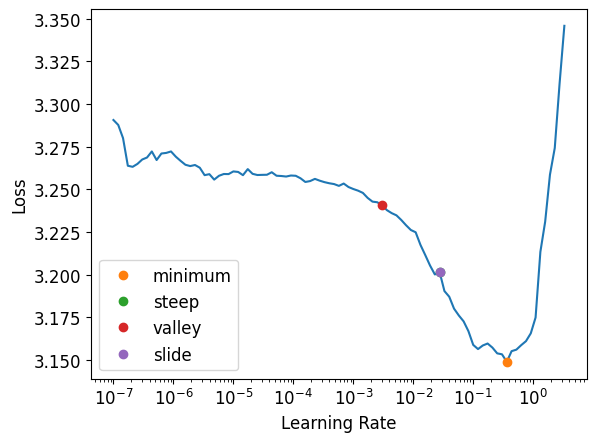

In [63]:
lrs = learner.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [64]:
print(f"Tasa de aprendizaje óptima escogida : {round(lrs.valley,5)}")

Tasa de aprendizaje óptima escogida : 0.00302


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,3.171309,3.147196,0.097600,0.061130,00:22
1,3.036895,2.999909,0.125600,0.071949,00:16
2,2.884422,2.836519,0.166400,0.128879,00:16
3,2.743506,2.708916,0.186400,0.153851,00:16
4,2.646935,2.623174,0.203200,0.175331,00:16
5,2.558784,2.550672,0.227200,0.186060,00:16
6,2.468946,2.457385,0.268000,0.242791,00:17
7,2.364707,2.361333,0.291200,0.261316,00:16
8,2.276262,2.498911,0.240000,0.213709,00:16
9,2.188086,2.282127,0.309600,0.282871,00:16


Better model found at epoch 0 with valid_loss value: 3.147195816040039.
Better model found at epoch 1 with valid_loss value: 2.999908685684204.
Better model found at epoch 2 with valid_loss value: 2.8365190029144287.
Better model found at epoch 3 with valid_loss value: 2.7089157104492188.
Better model found at epoch 4 with valid_loss value: 2.6231744289398193.
Better model found at epoch 5 with valid_loss value: 2.5506715774536133.
Better model found at epoch 6 with valid_loss value: 2.4573850631713867.
Better model found at epoch 7 with valid_loss value: 2.3613333702087402.
Better model found at epoch 9 with valid_loss value: 2.2821266651153564.
Better model found at epoch 10 with valid_loss value: 2.101712942123413.
Better model found at epoch 13 with valid_loss value: 1.970102310180664.
Better model found at epoch 15 with valid_loss value: 1.9359831809997559.
Better model found at epoch 17 with valid_loss value: 1.9340351819992065.
Better model found at epoch 18 with valid_loss valu

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

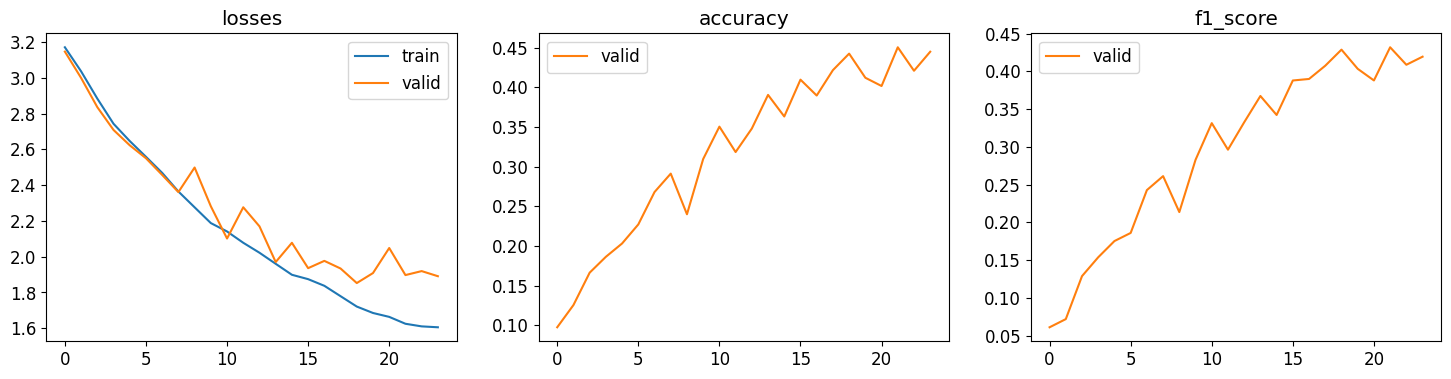

In [65]:
cbs=[SaveModelCallback(), EarlyStoppingCallback(min_delta=0.01, patience=5)]
learner.fit_one_cycle(n_epoch=50, lr_max=lrs.valley,cbs=cbs)
learner.recorder.plot_metrics()

In [66]:
val_loss, val_accuracy, val_f1 = learner.validate()
print(f"Pérdida en val: {val_loss}, Accuracy en val: {round(100*val_accuracy, 3)}, F1 en val: {val_f1}")

Pérdida en val: 1.8526517152786255, Accuracy en val: 44.24, F1 en val: 0.4288076255448025


Vamos a proceder a realizar ciertos cambios sobre nuestro modelo actual, con el objetivo de mejorarlo aun más.

En lugar de emplear una convolución 1x1 para el ajuste entre un bloque y otro, implementaremos dicho ajuste en la primera capa de cada bloque, ahorrándonos la convolución mencionada. Ahora, la primera capa de nuestro bloque usará el stride indicado para reducir tamaño, y empleará tantos filtros como canales de salida deseemos. La segunda y última capa del bloque mantiene la misma funcionalidad inicial, preservando tamaño y nº canales.

In [96]:
#construimos las dos capas convolucionales que conforman un bloque residual (sin implementar aún la conexión de salto)
def bloque_conv(ni,nf,stride):
    return nn.Sequential(
        ConvLayer(ni, nf, stride=stride),
        ConvLayer(nf, nf, act_cls=None, norm_type=NormType.BatchZero))

Al integrar el reajuste en la primera capa del bloque, la salida de las convoluciones y la entrada a dicho bloque podrían tener diferentes dimensiones. Por ende, tendremos que transformar adecuadamente la entrada antes de sumarle la salida de las capas.

**¿Cómo se reajustan las dimensiones de la entrada al bloque?**

Podríamos comenzar pensando en usar una convolución 1x1 que ajuste tanto el tamaño (usando el stride correspondiente) como el nº de canales de la imagen de entrada. Sin embargo, esto supondría ignorar una cantidad importante de información, al emplear un stride superior a 1.

Por ello, optaremos por implementar dicha conexión de salto siguiendo la idea que se propone en el artículo **Bag of Tricks for Image Classification with Convolutional Neural Networks**: en lugar de usar una solo convolución 1x1 sobre la entrada, empleamos una convolución 1x1 (para ajustar nº de canales) y un AveragePooling (para resumir información y obteniendo el tamaño deseado).


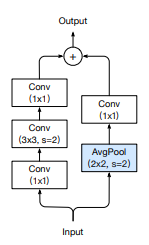

Tal y como se ha visto en el último modelo definido, siempre reduzco a la mitad cada dimensión de la imagen (filas y columnas), contrarrestando dicha reducción duplicando el nº de canales. Por ende, el `AveragePooling` empleado será de tamaño 2x2, con stride por defecto (tamaño del kernel) y padding por defecto (=0).

In [97]:
class BloqueResidual(Module):
    def __init__(self, ni, nf, stride=1):
        #tomamos las capas convolucionales que conforman dicho bloque
        self.convs = bloque_conv(ni,nf,stride)
        #comprobamos si se quiere cambiar el nº de canales de la imagen de entrada. En caso afirmativo, aplicar una convolución 1x1 con stride=1
        #importante desactivar activación ya que estamos simplemente trabajando sobre la entrada que va a saltar.
        self.idconv = noop if ni==nf else ConvLayer(ni, nf, 1, act_cls=None)
        #en caso de haber cambiado el tamaño de la imagen original,redimensionamos usamos el average pool comentado
        self.pool = noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)

    def forward(self, x):
        #devolvemos la entrada (correctamente ajustada) sumada con la salida del bloque de capas convolucionales
        return F.relu(self.convs(x) + self.idconv(self.pool(x)))

Además de todo lo realizado hasta ahora, voy a introducir una serie de capas iniciales en mi modelo que serán capas convolucionales planas (sin definir conexiones de salto entre ellas). Esto es importante por el hecho de que en redes neuronales profundas, **la mayor parte del cálculo se realiza en las primeras capas**, al comenzar trabajando con imágenes de alta resolución, lo que supone aplicar muchas veces el kernel correspondiente. En el caso de usar `stride=1`, habría que aplicarlo tantas veces como píxeles tenga la imagen. Conforme la imagen va transcurriendo por las diferentes capas de la red, su resolución se verá reducida, lo que supondrá ir aplicando un menor nº de veces kernesl posteriores. Por ende, debemos intentar que estas capas iniciales sean lo más rápidas posibles, para hacer frente a este coste computacional inicial.

Si colocásemos un bloque residual al inicio de la red, al estar conformado por varias convoluciones, todo ello sumado a trabajar con imágenes iniciales de alta resolución, supondría un impacto significativo en el coste computacional. Por esta razón, se prefiere comenzar una Resnet empleando convoluciones simples.

Respetando lo comentado, las capas iniciales de nuestro modelo supondrán la mayor parte del coste computacional, mientras que las restantes (bloques residuales) contendrán la mayor parte de los parámetros del modelo (manteniendo así la capacidad del modelo en capas más profundas de aprender características más abstractas, haciendo frente a la reducción espacial).

Siguiendo la estructura de la ultima red definida, la adaptaré utilizando los nuevos bloques residuales definidos y siguiendo la estructura moderna de ResNet:
* La primera capa convolucional inicialmente definida, generando 16 canales de salida, pero preservando la resolución de la imagen.
* Una serie de etapas (en mi caso tres etapas de dos bloques cada una), tal que:
  * Cada etapa está conformada por una serie de bloques residuales
  * El paso de una etapa a otra implicará reducir a la mitad las dimensiones de la imagen y duplicar el nº de canales. Por ello, se empleará el 1º bloque de cada etapa para llevar a cabo ese proceso de **downsampling**.
  * Como las imágenes del dataset tienen una muy baja resolución (32x32), he decidido no reducir su resolución ni en la primera capa convolucional del modelo ni en la primera etapa, aunque se incremente el nº de canales de salida (con intención de comenzar capturando muchas características básicas de la imagen original sobre las que trabajar en capas más profundas).
* Usamos un AveragePool para realizar un promedio sobre cada uno de los canales de la imagen que devuelve como salida la última etapa
* Aplanamos y usamos una última capa fully-connected para devolver las salidas deseadas (en nuestro problema, las 25 clases a predecir)

La siguiente imagen ilustra la arquitectura seguida, aunque no con total exactitud.

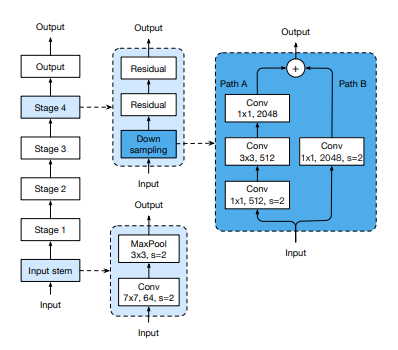

In [98]:
def get_model():
  return sequential (
      ConvLayer(3,16),
      #1º etapa
      BloqueResidual(16,16),
      BloqueResidual(16,16),
      #2º etapa
      BloqueResidual(16,32,stride=2),
      BloqueResidual(32,32),
      #3º etapa
      BloqueResidual(32,64,stride=2),
      BloqueResidual(64,64),
      #fin de las etapas
      nn.AdaptiveAvgPool2d(1),
      nn.Flatten(),
      nn.Linear(64,25)
  )
get_model()

Sequential(
  (0): ConvLayer(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (1): BloqueResidual(
    (convs): Sequential(
      (0): ConvLayer(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (1): ConvLayer(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (2): BloqueResidual(
    (convs): Sequential(
      (0): ConvLayer(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Re

In [99]:
learner=Learner(dls, get_model(), metrics=[accuracy,F1Score(average='weighted')],
                loss_func=CrossEntropyLossFlat(),  #new loss-function
                opt_func=Adam, wd=0.001)

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

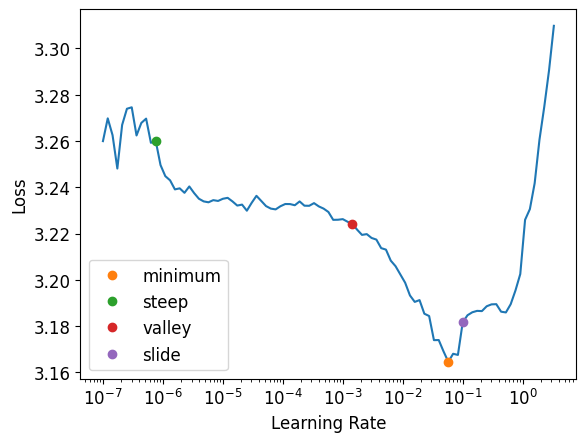

In [100]:
lrs = learner.lr_find(suggest_funcs=(minimum, steep, valley, slide))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,3.118108,3.088997,0.108800,0.055009,00:33
1,2.948796,2.935060,0.134400,0.093926,00:26
2,2.825508,2.785670,0.173600,0.137730,00:23
3,2.720692,2.674837,0.201600,0.168714,00:25
4,2.600118,2.590843,0.210400,0.178483,00:23
5,2.484805,2.409523,0.274400,0.251170,00:25
6,2.339436,2.442382,0.268800,0.252074,00:23
7,2.241931,2.261518,0.336800,0.308048,00:25
8,2.166158,2.159805,0.343200,0.325437,00:23
9,2.065811,2.353863,0.323200,0.291951,00:25


Better model found at epoch 0 with valid_loss value: 3.0889968872070312.
Better model found at epoch 1 with valid_loss value: 2.9350600242614746.
Better model found at epoch 2 with valid_loss value: 2.785670042037964.
Better model found at epoch 3 with valid_loss value: 2.6748366355895996.
Better model found at epoch 4 with valid_loss value: 2.590843439102173.
Better model found at epoch 5 with valid_loss value: 2.4095230102539062.
Better model found at epoch 7 with valid_loss value: 2.2615180015563965.
Better model found at epoch 8 with valid_loss value: 2.1598050594329834.
Better model found at epoch 10 with valid_loss value: 1.9720113277435303.
Better model found at epoch 12 with valid_loss value: 1.8788806200027466.
Better model found at epoch 13 with valid_loss value: 1.8128248453140259.
Better model found at epoch 17 with valid_loss value: 1.674816608428955.
Better model found at epoch 18 with valid_loss value: 1.6372663974761963.
Better model found at epoch 21 with valid_loss va

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

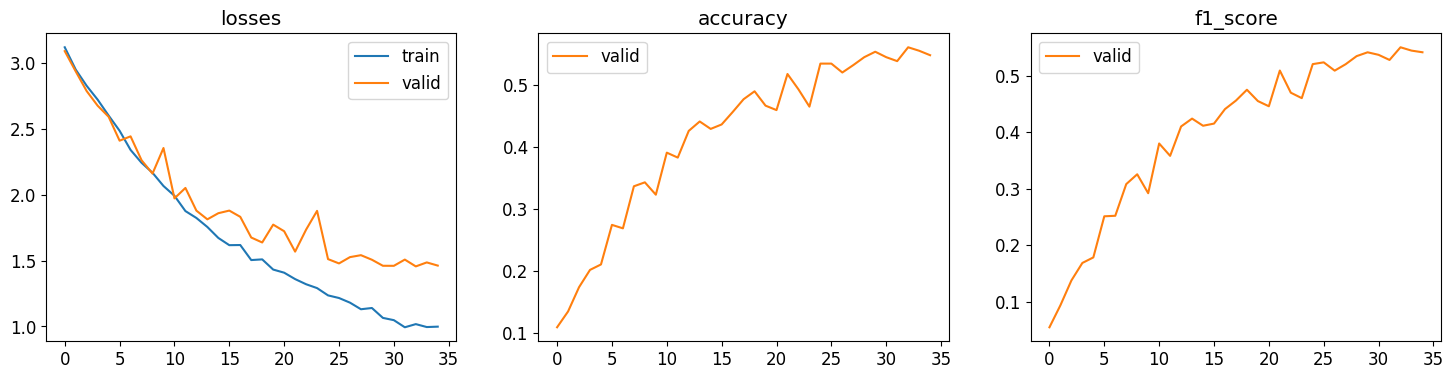

In [101]:
cbs=[SaveModelCallback(), EarlyStoppingCallback(min_delta=0.01, patience=5)]
learner.fit_one_cycle(n_epoch=40, lr_max=lrs.valley,cbs=cbs)
learner.recorder.plot_metrics()

In [102]:
val_loss, val_accuracy, val_f1 = learner.validate()
print(f"Pérdida en val: {val_loss}, Accuracy en val: {round(100*val_accuracy, 3)}, F1 en val: {val_f1}")

Pérdida en val: 1.4558132886886597, Accuracy en val: 56.16, F1 en val: 0.5499105523332428




---



Para seguir mejorando mi modelo actual, basado en el uso de bloques residuales, podría comenzar optando por **aumentar la profundidad de la red**, ya sea incrementando el nº de etapas o el nº de bloques en cada etapa, empleando, además, una alternativa de diseño del bloque residual conocida como **cuello de botella**, que implica sustituir las 2 convoluciones 3x3 por tres convoluciones 1x1,3x3 y 1x1. Estas convoluciones 1x1 simplemente tienen el objetivo de reducir y restaurar el nº de canales, respectivamente.

Gracias a este nuevo diseño, podremos trabajar con un mayor nº de características en el mismo tiempo y reducir el coste computacional en comparación al diseño inicial del bloque residual.

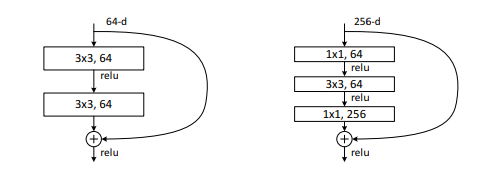

Este nuevo diseño del bloque residual nos permite "adelgazar" la red residual, permitiéndonos construir redes residuales mucho más profundas sin aumentar de forma desmesurada el costo computacional.

Sin embargo, en ciertos artículos científicos se propone como alternativa para mejorar nuestra red residual, **ensanchar las redes residuales**, es decir, incrementar el nº de filtros de las diferentes capas, en lugar de limitarnos a profundizar la red, produciendo incluso mejores resultados que si incrementásemos la profundidad del modelo. Estos modelos se conocen como **wide residual networks**.

Además, se nos indica lo siguiente:
* Para mejorar levemente el rendimiento de una red residual basada en bloques residuales en cuello de botella incrementando su profundidad, sería necesario añadir muchísimas nuevas capas para lograr una pequeña mejora, incrementando muchísimo el coste computacional.
* Para buscar una leve mejora en una *wide residual net*, podría bastar con duplicar el nº de parámetros del modelo, evitando incrementar tantísimo la complejidad de dicho modelo.

En resumen, existen varias formas de aumentar la capacidad de aprendizaje de un bloque residual:
- Aumentar el nº de convoluciones por bloque
- Aumentar nº de filtros de las capas convolucionales
- Aumentar tamaño de los filtros que emplean las convoluciones

Se ha comprobado que filtros pequeños suelen ser más efectivos, por lo que las posibles estrategias a seguir serían las dos primeras. En este caso, y tal y como he indicado, me reduciré a ensanchar las capas convolucionales, incrementando el nº de filtros que aplican.

Para ello, redefiniré el último modelo construido, pero especificando como parámetro el factor de ensanchamiento a aplicar, permitiéndonos multiplicar el nº de filtros de las capas convolucionales de nuestra red residual por el factor especificado, lo que supone ensanchar dichas capas.

In [103]:
def get_model(factor_anchura=1):
    return sequential (
        ConvLayer(3, 16 * factor_anchura),
        # 1º etapa
        BloqueResidual(16 * factor_anchura, 16 * factor_anchura),
        BloqueResidual(16 * factor_anchura, 16 * factor_anchura),
        # 2º etapa
        BloqueResidual(16 * factor_anchura, 32 * factor_anchura, stride=2),
        BloqueResidual(32 * factor_anchura, 32 * factor_anchura),
        # 3º etapa
        BloqueResidual(32 * factor_anchura, 64 * factor_anchura, stride=2),
        BloqueResidual(64 * factor_anchura, 64 * factor_anchura),
        # fin de las etapas
        nn.AdaptiveAvgPool2d(1),
        nn.Flatten(),
        nn.Linear(64 * factor_anchura, 25)
    )

Me limitaré a comprobar si realmente mi modelo consigue mejorar utilizando factores de ensanchamiento x2 y x3, y empleando un tamaño de batch de 32.

En este caso, procedo a reducir el tamaño de lote, permitiendo un **mayor nº de actualizaciones** de los parámetros del modelo, aunque esto suponga un entrenamiento más lento. Además, emplear lotes más pequeños implicará obtener el promedio de los gradientes sobre un menor nº de datos, introduciendo un mayor ruido en el proceso de actualización de los pesos, **mejorando la capacidad de generalización** del modelo.


Entrenando modelo con factor de ensanchamiento x2 y batch size 32


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,2.996267,2.945166,0.144800,0.106495,00:24
1,2.818990,2.759954,0.182400,0.146321,00:24
2,2.665927,2.641882,0.202400,0.163794,00:23
3,2.558036,2.488548,0.242400,0.218622,00:25
4,2.390379,2.530492,0.264000,0.259743,00:23
5,2.282834,2.263175,0.314400,0.290857,00:25
6,2.157881,2.263860,0.318400,0.289743,00:23
7,2.006530,2.430123,0.322400,0.314458,00:25
8,1.915602,2.401186,0.335200,0.304938,00:23
9,1.838904,2.002958,0.406400,0.389437,00:25


Better model found at epoch 0 with valid_loss value: 2.9451661109924316.
Better model found at epoch 1 with valid_loss value: 2.759953737258911.
Better model found at epoch 2 with valid_loss value: 2.6418819427490234.
Better model found at epoch 3 with valid_loss value: 2.4885475635528564.
Better model found at epoch 5 with valid_loss value: 2.2631752490997314.
Better model found at epoch 9 with valid_loss value: 2.002958297729492.
Better model found at epoch 10 with valid_loss value: 1.7204316854476929.
Better model found at epoch 13 with valid_loss value: 1.6661465167999268.
Better model found at epoch 14 with valid_loss value: 1.5180751085281372.
Better model found at epoch 16 with valid_loss value: 1.501370906829834.
Better model found at epoch 18 with valid_loss value: 1.4825527667999268.
Better model found at epoch 20 with valid_loss value: 1.4460450410842896.
Better model found at epoch 21 with valid_loss value: 1.4409931898117065.
Better model found at epoch 22 with valid_loss 

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

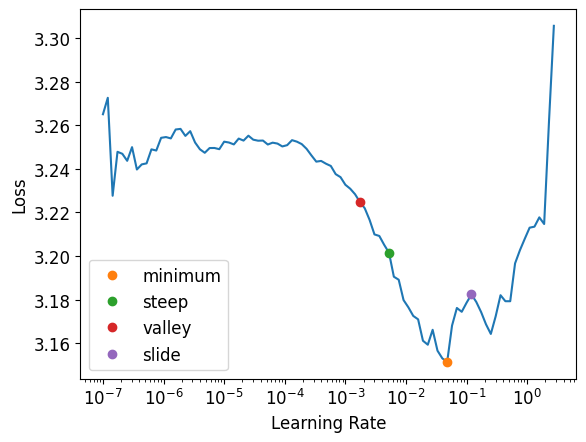

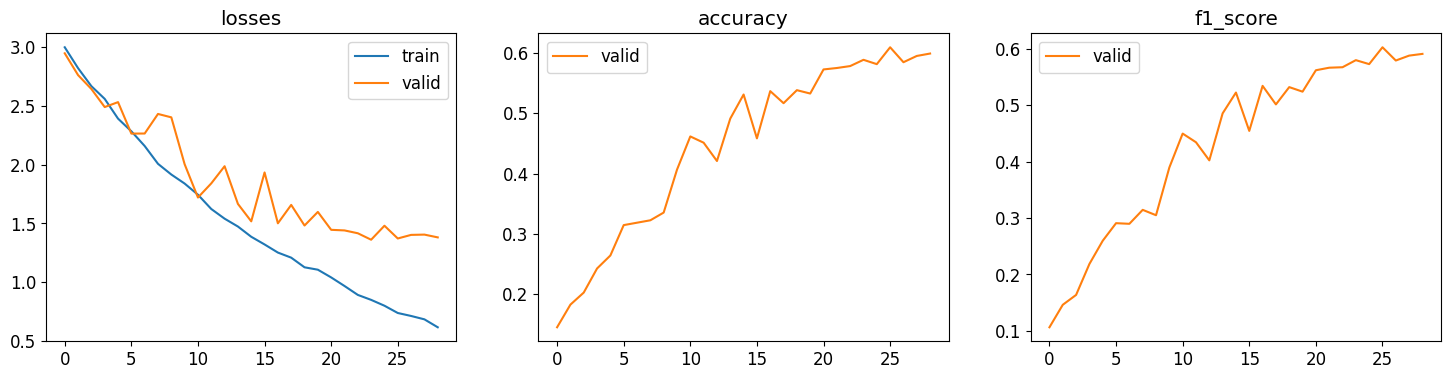


Entrenando modelo con factor de ensanchamiento x3 y batch size 32


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,3.117505,3.090762,0.099200,0.057180,00:25
1,2.952468,2.928990,0.149600,0.107397,00:23
2,2.834904,2.800938,0.179200,0.148696,00:25
3,2.714376,2.707646,0.195200,0.169584,00:23
4,2.653564,2.599069,0.222400,0.194744,00:25
5,2.538323,2.484246,0.257600,0.232087,00:23
6,2.391271,2.380122,0.276000,0.244512,00:25
7,2.291670,2.245313,0.333600,0.325246,00:23
8,2.171868,2.295554,0.330400,0.311898,00:25
9,2.023846,2.001366,0.384000,0.370931,00:23


Better model found at epoch 0 with valid_loss value: 3.0907623767852783.
Better model found at epoch 1 with valid_loss value: 2.9289896488189697.
Better model found at epoch 2 with valid_loss value: 2.800938129425049.
Better model found at epoch 3 with valid_loss value: 2.707646131515503.
Better model found at epoch 4 with valid_loss value: 2.599069356918335.
Better model found at epoch 5 with valid_loss value: 2.4842464923858643.
Better model found at epoch 6 with valid_loss value: 2.3801217079162598.
Better model found at epoch 7 with valid_loss value: 2.2453131675720215.
Better model found at epoch 9 with valid_loss value: 2.001365900039673.
Better model found at epoch 10 with valid_loss value: 1.9775285720825195.
Better model found at epoch 13 with valid_loss value: 1.7948945760726929.
Better model found at epoch 15 with valid_loss value: 1.7368048429489136.
Better model found at epoch 16 with valid_loss value: 1.721047282218933.
Better model found at epoch 17 with valid_loss value

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

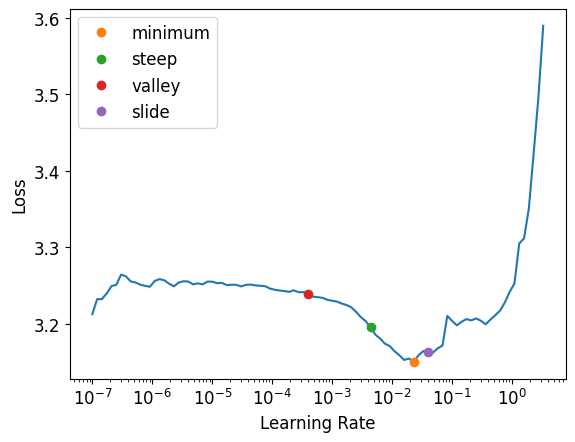

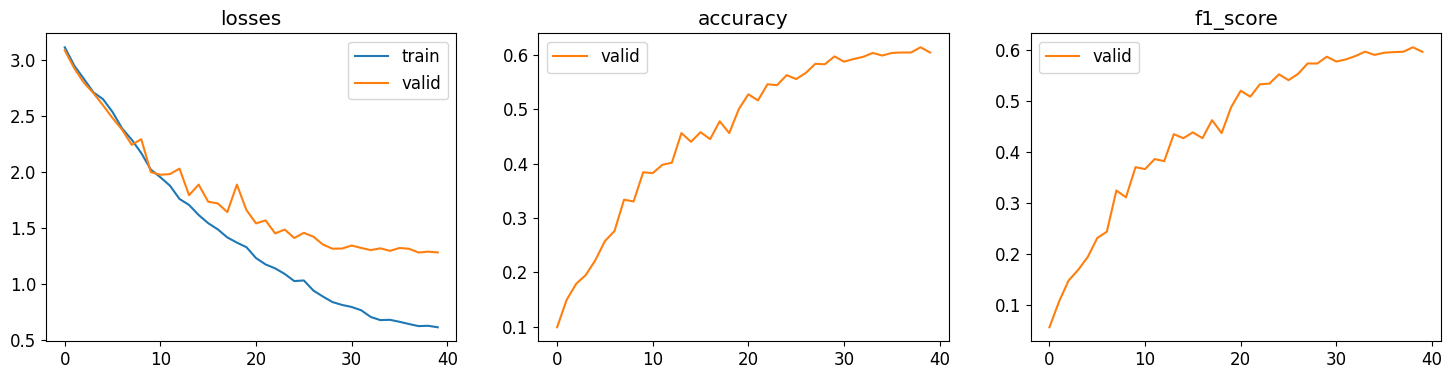

In [104]:
#Factor de ensanchamiento
multipliers = [2, 3]
#Tamaños de batch
batch_sizes = [32]
# Tabla de resultados
results = []
# Learners entrenados
learners = {}

# Bucle de entrenamiento
for multiplier in multipliers:
    for batch_size in batch_sizes:
        print(f"\nEntrenando modelo con factor de ensanchamiento x{multiplier} y batch size {batch_size}")

        # Crea los dataloaders con el tamaño de batch especificado
        dls=dblock.dataloaders(path/'train',bs=batch_size,drop_last=False)
        dls.train.sampler = RandomSampler(dls.train.dataset,generator=gen)

        # Define el modelo y el learner
        learner=Learner(dls, get_model(factor_anchura=multiplier), metrics=[accuracy,F1Score(average='weighted')],
                loss_func=CrossEntropyLossFlat(),  #new loss-function
                opt_func=Adam, wd=0.001)
        #nombre del modelo
        model_name=f"model_width_{multiplier}_batch_{batch_size}"
        #buscamos la tasa de aprendizaje óptima
        lrs = learner.lr_find(suggest_funcs=(minimum, steep, valley, slide))

        # Entrena el modelo
        cbs = [SaveModelCallback(), EarlyStoppingCallback(min_delta=0.01, patience=5)]
        learner.fit_one_cycle(n_epoch=40, lr_max=lrs.valley, cbs=cbs)
        # Muestra las curvas de entrenamiento
        learner.recorder.plot_metrics()

        # Guarda las métricas de validación
        val_loss, val_accuracy, val_f1 = learner.validate()
        results.append({
            "Factor de anchura": multiplier,
            "Tamaño de lote": batch_size,
            "Error de validación": val_loss,
            " F1 Score" : val_f1,
            "Tasa de clasificación en validación": round(100 * val_accuracy, 3),
            "Modelo guardado": model_name
        })

        #Guardamos el modelo una vez entrenado
        learners[model_name]=learner

Una vez entrenado los diferentes modelos con los diferentes tamaños de lote empleados, generamos una tabla que nos permite ilustrar y visualizar los resultados obtenidos en cuanto a error y accuracy de validación obtenidos.

In [105]:
# Convierte los resultados a un DataFrame
results_df = pd.DataFrame(results)

In [106]:
# Estilizar el DataFrame para centrar las columnas, aumentar el espacio entre ellas y eliminar los índices
styled_df = results_df.style.set_table_styles(
    [{'selector': 'th', 'props': [('text-align', 'center'), ('padding', '10px')]},  # Centrar los encabezados
     {'selector': 'td', 'props': [('text-align', 'center'), ('padding', '10px')]}  # Centrar las celdas y aumentar padding
    ]
).set_table_attributes('style="width: 100%; border-collapse: separate; border-spacing: 10px;"') \

# Mostrar el DataFrame con estilo (en un entorno como Jupyter o similar)
styled_df.hide(axis="index")

Factor de anchura,Tamaño de lote,Error de validación,F1 Score,Tasa de clasificación en validación,Modelo guardado
2,32,1.362001,0.579583,58.880000,model_width_2_batch_32
3,32,1.282303,0.597138,60.400000,model_width_3_batch_32


Observando la tabla previa, podemos concluir que aumentar el nº de filtros de las convoluciones nos ha permitido obtener pequeñas mejoras sobre el modelo base, que nos ofrecía una accuracy en validación de un 56.16%.
  * Aplicar un **factor de ensanchamiento x2** nos ha permitido obtener una **mejora de un 2.72%** en cuanto a la val_accuracy
  * Aplicar un **factor de ensanchamiento x3** nos ha permitido obtener una **mejora de un 4.24%** en cuanto a la val_accuracy

Seleccionamos como mejor modelo el que nos ha ofrecido una mayor accuracy en validación, en este caso, el último generado tras ensanchar x3 las convoluciones del modelo base.

In [107]:
best_learner=learners["model_width_3_batch_32"]
best_learner.summary()

Sequential (Input shape: 32 x 3 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 48 x 32 x 32   
Conv2d                                    1296       True      
BatchNorm2d                               96         True      
ReLU                                                           
Conv2d                                    20736      True      
BatchNorm2d                               96         True      
ReLU                                                           
Conv2d                                    20736      True      
BatchNorm2d                               96         True      
Conv2d                                    20736      True      
BatchNorm2d                               96         True      
ReLU                                                           
Conv2d                                    20736      True      
BatchNorm2d                               96         True      
___________________

En cuanto a las curvas de aprendizaje del modelo seleccionado...

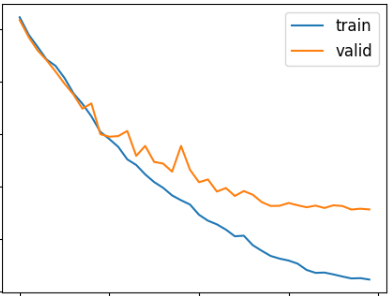

* El modelo con factor de ensanchamiento x3 se ha entrenado durante las 40 épocas inicialmente fijadas, sin haberse aplicado early_stopping. Podríamos haber optado por aumentar el nº de épocas de entrenamiento, aunque visualizando las curvas, no parece que esto hubiese permitido al modelo seguir mejorando, ya que podemos apreciar cómo la pérdida de validación se mantiene más o menos estable en las últimas épocas de entrenamiento, a pesar de que el error de training siga disminuyendo, siendo probable por tanto que se aplicase early_stopping en las siguientes épocas.

* Además, este último modelo presenta un cierto sobreajuste que podríamos intentar reducir, en caso de que lo deseemos, probando otras técnicas de regularización, o aumentando el mínimo de mejora especificado en `early_stopping`, deteniendo el proceso de entrenamiento antes y quedándonos con el modelo obtenido en épocas previas, o incluso entrenando simplemente el modelo durante un menor nº de épocas, evitando que se ajuste demasiado a los datos de entrenamiento, buscando ese equilibrio entre bias y variance.

  Un punto interesante en el que podríamos, por ejemplo, haber detenido el entrenamiento, sería en la marca indicada, a partir de la cual la varianza comienza a subir, y el sesgo a bajar.

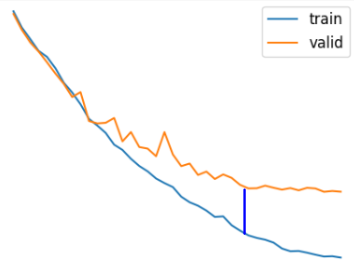

# Evaluación del mejor modelo en test

In [108]:
#dataloader de test a partir de las imagenes de test
test_dl = best_learner.dls.test_dl(get_image_files(path/'test'),with_labels=True)

In [109]:
preds, targs, _ = best_learner.get_preds(dl=test_dl, with_decoded=True)
acc = accuracy(preds, targs)
print('The test accuracy is : ', round(float(acc)*100, 4), '%')

The test accuracy is :  61.32 %


Tras evaluar el modelo final en test, obtenemos una accuracy de un 61.32%. Procedemos también a visualizar la matriz de confusión (en test), además de imprimir las diez imágenes de test de mayor pérdida.

Number of test examples: 2500


Test Accuracy
61.31999999999999


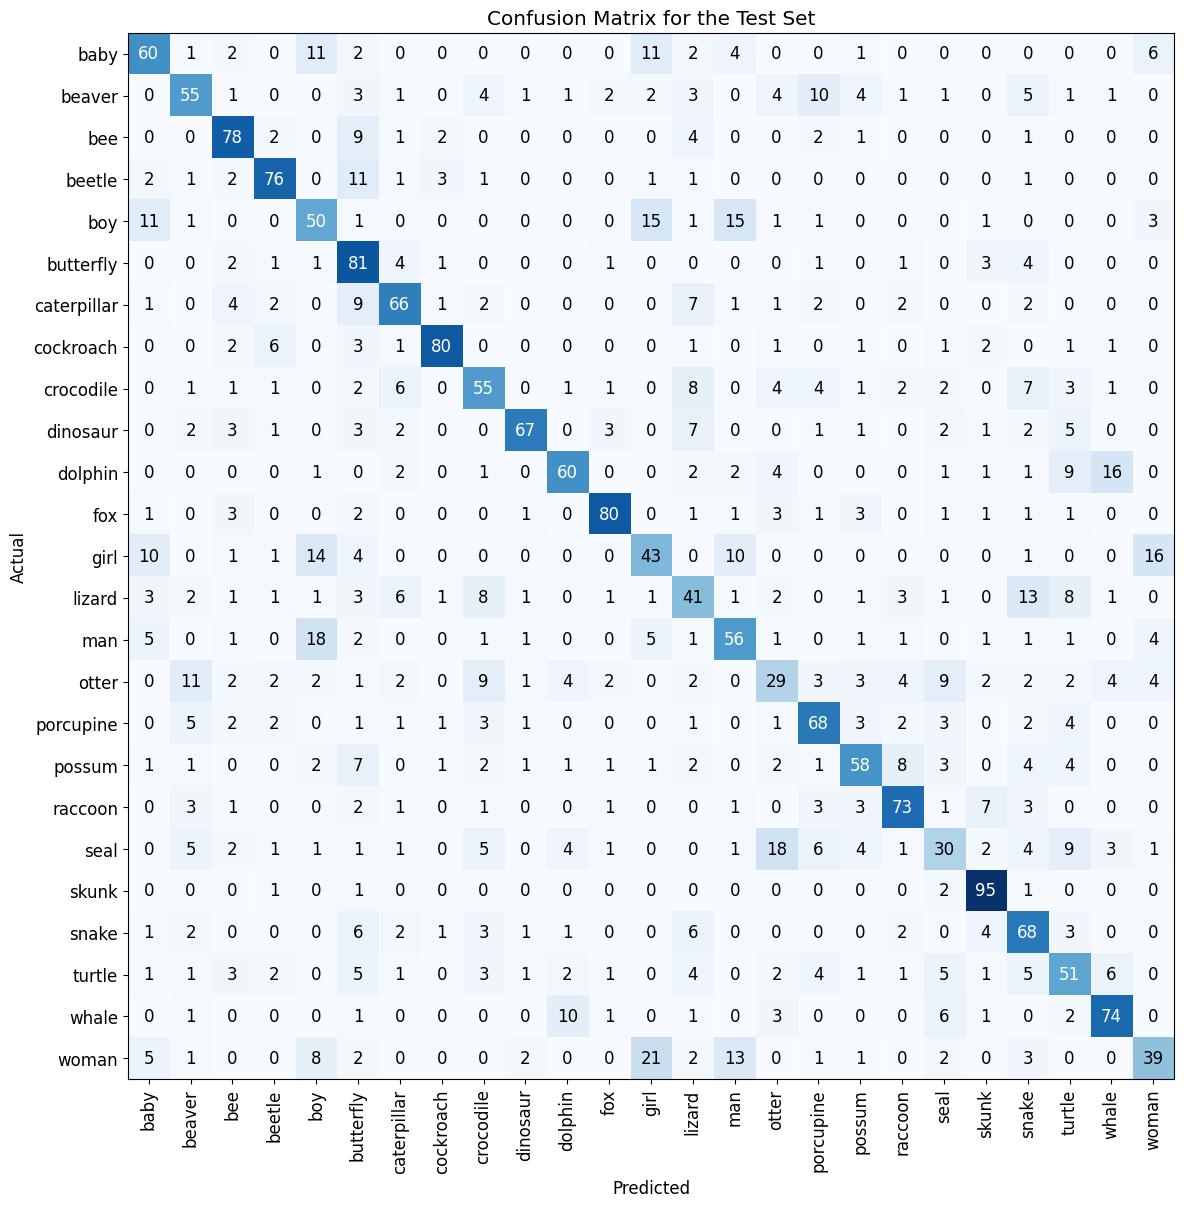

In [110]:
interp = ClassificationInterpretation.from_learner(best_learner, 1, test_dl)
#geenramos la matriz de confusión
cm = interp.confusion_matrix()
print('Number of test examples:', np.sum(cm))
interp.plot_confusion_matrix(figsize=(12, 12),title='Confusion Matrix for the Test Set')
print('Test Accuracy')
print(np.sum(np.diagonal(cm))/np.sum(cm)*100)

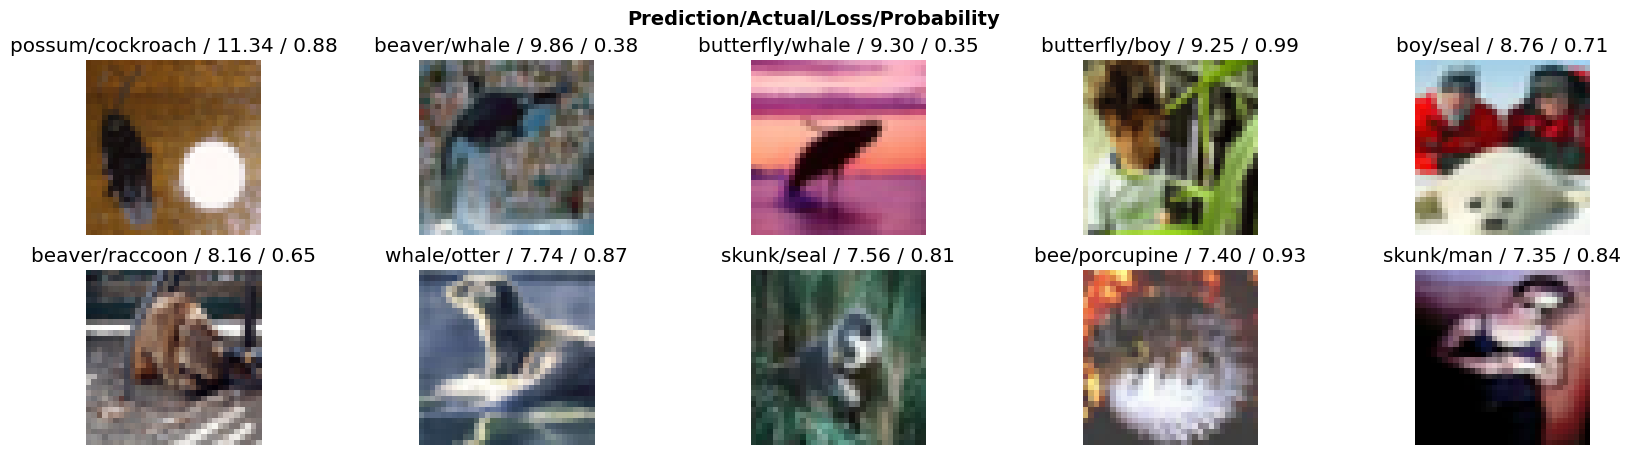

In [111]:
interp.plot_top_losses(10, nrows=2, figsize=(20, 5))
plt.subplots_adjust(wspace=0.5)